# Part A: Newtonian Dynamics 

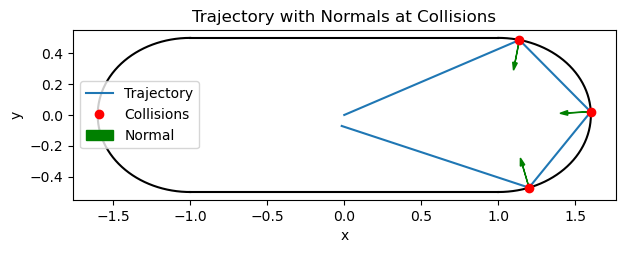

Collision 0: angle_in = 55.8087 deg, angle_out = 55.8087 deg, diff = 1.11e-16 rad
Collision 1: angle_in = 48.0280 deg, angle_out = 48.0280 deg, diff = 1.11e-16 rad
Collision 2: angle_in = 55.4503 deg, angle_out = 55.4503 deg, diff = 2.22e-16 rad
Plot saved as: r1.png


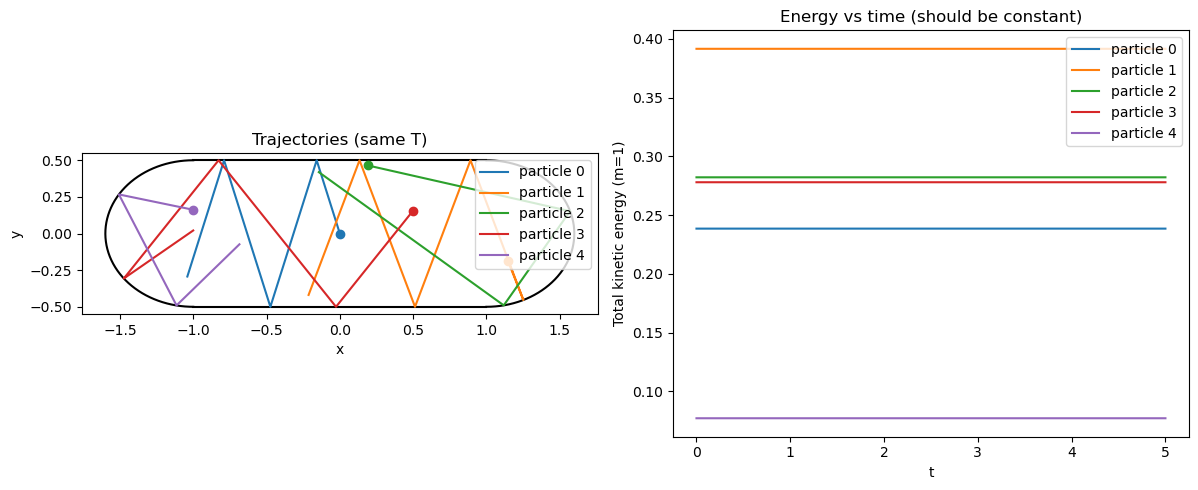

Plot saved as: r2.png


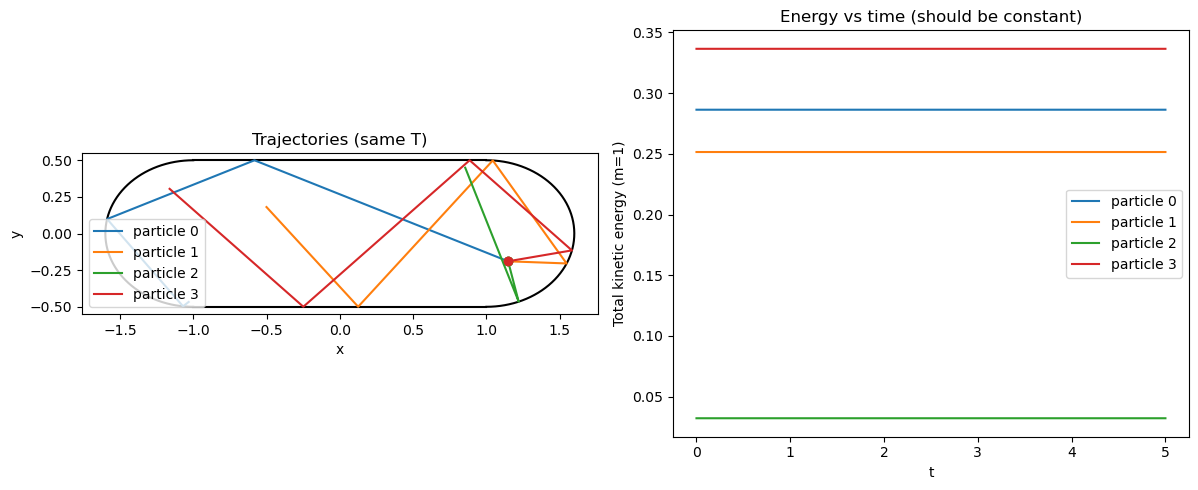

Plot saved as: r3.png


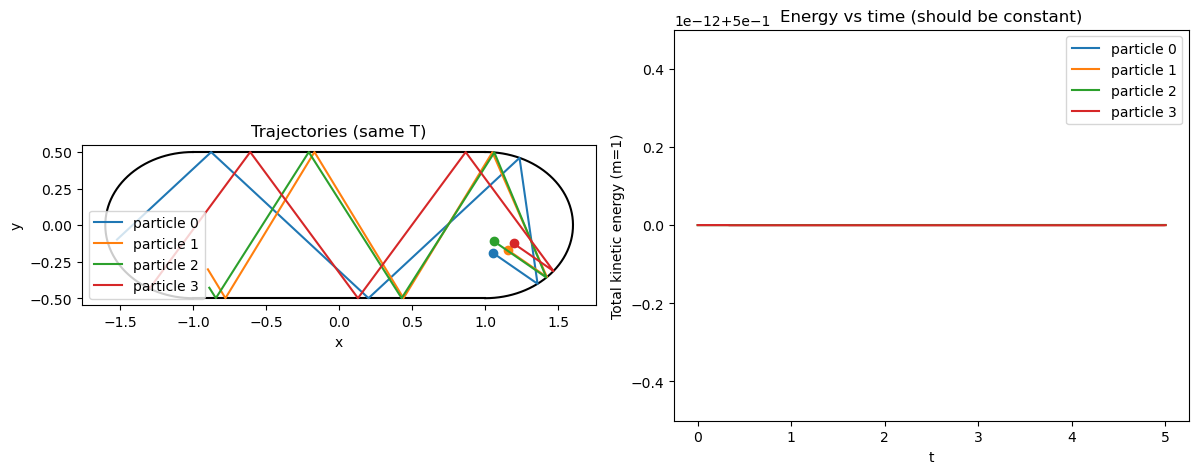

Plot saved as: r4.png


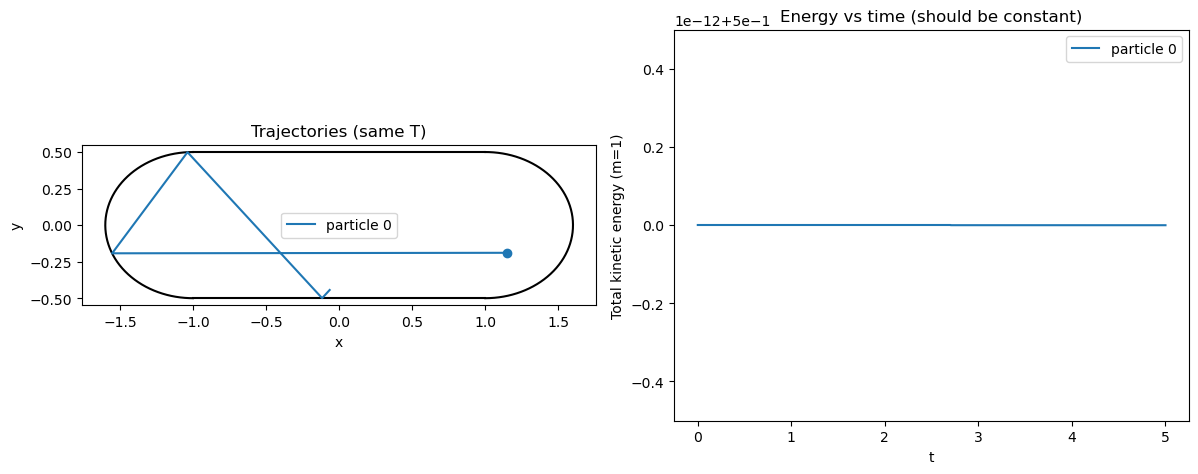

Plot saved as: r5.png


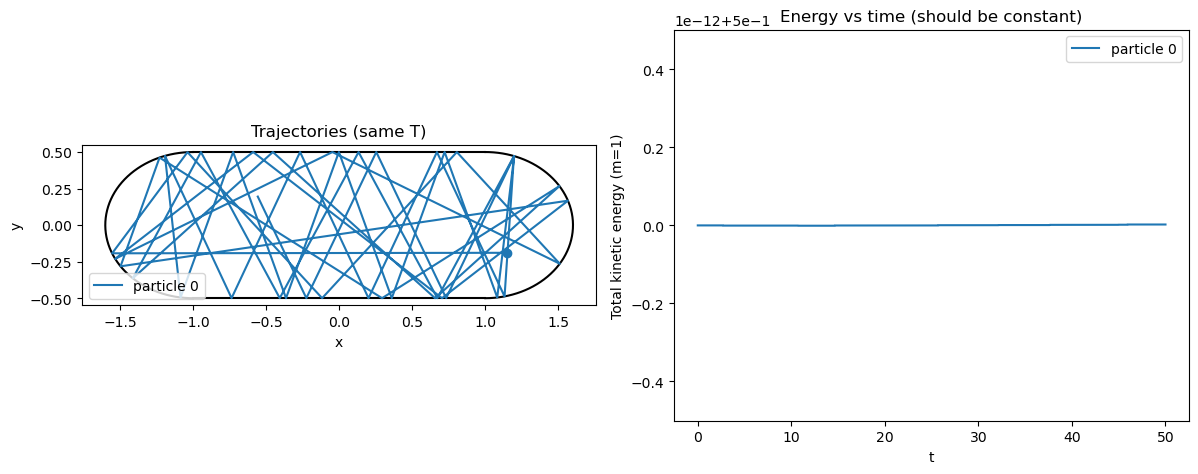

Plot saved as: r6.png


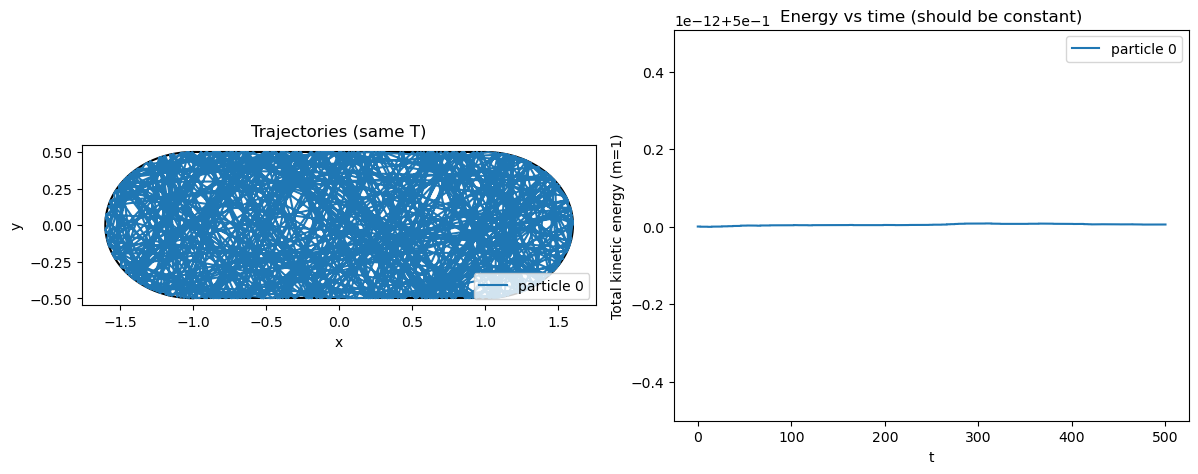

In [9]:
"""
Stadium (rectangle + elliptic caps) Newtonian dynamics with elastic reflection.

Provided functions:
 - is_inside_stadium(x,y,a,b,rx,ry)
 - sample_point_in_stadium(a,b,rx,ry)    # uniform inside (no rejection)
 - sample_point_on_boundary(a,b,rx,ry)   # uniform on boundary by arc-length
 - boundary_normal(x,y,a,b,rx,ry)        # inward unit normal at boundary point (geometric)
 - reflect_velocity(v, n)                # elastic reflection using inward normal n
 - integrate_trajectories(initial_conditions, a,b,rx,ry, dt, T)  # stepper with collision detection
 - utilities to plot trajectories and energies

Assumptions explicitly written in header comments above.
"""
import numpy as np
import matplotlib.pyplot as plt
from math import pi, sqrt, sin, cos
from typing import Tuple

# ---------------------------
# Geometry & analytic helpers
# ---------------------------

def is_inside_stadium(x: float, y: float, a: float, b: float, rx: float, ry: float) -> bool:
    """
    Test whether (x,y) is inside the stadium: rectangle |x|<=a,|y|<=b plus
    half-ellipses attached at x = +/- a.
    """
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2) / (rx**2) + (y**2) / (ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2) / (rx**2) + (y**2) / (ry**2) <= 1.0

def ellipse_half_area(rx: float, ry: float) -> float:
    """Area of a half-ellipse."""
    return 0.5 * pi * rx * ry

def stadium_area(a: float, b: float, rx: float, ry: float) -> float:
    """Total area: rectangle + two half-ellipses."""
    A_rect = 2*a * 2*b  # full rectangle
    A_caps = 2 * ellipse_half_area(rx, ry)
    return A_rect + A_caps

def approximate_ellipse_circumference(rx: float, ry: float) -> float:
    """Ramanujan approximation for ellipse circumference"""
    h = ((rx - ry)**2) / ((rx + ry)**2)
    C = pi * (rx + ry) * (1 + (3*h)/(10 + sqrt(4 - 3*h)))
    return C

def half_ellipse_arc_length(rx: float, ry: float) -> float:
    """Approximate half-ellipse arc length as half the full circumference (good approximation)."""
    return 0.5 * approximate_ellipse_circumference(rx, ry)

# ---------------------------
# Uniform sampling (no rejection)
# ---------------------------

def sample_point_in_stadium(a: float, b: float, rx: float, ry: float) -> Tuple[float,float]:
    """
    Uniform sampling inside stadium by area partition:
    - Sample whether point lies in rectangle or in left/right half-ellipse based on areas.
    - For rectangle: uniform in x in [-a,a], y in [-b,b].
    - For half-ellipse: sample radius r = sqrt(u) (u~U(0,1)) and angle phi restricted to the half.
        For right half (center at +a): phi in [-pi/2, pi/2] (cos phi >= 0).
        For left half (center at -a): phi in [pi/2, 3pi/2] (cos phi <= 0).
      Map elliptical coordinates: (x,y) = center + (rx * r * cos phi, ry * r * sin phi).
    """
    A_rect = 4*a*b
    A_caps_total = pi * rx * ry
    A_total = A_rect + A_caps_total
    r = np.random.rand() * A_total
    if r < A_rect:
        # rectangle
        x = np.random.uniform(-a, a)
        y = np.random.uniform(-b, b)
        return (x, y)
    else:
        # pick left or right cap with equal area (they're symmetric)
        if np.random.rand() < 0.5:
            # right cap centered at (+a,0), phi in [-pi/2, pi/2]
            phi = np.random.uniform(-pi/2, pi/2)
            u = np.random.rand()
            rad = sqrt(u)
            x = a + rx * rad * np.cos(phi)
            y =       ry * rad * np.sin(phi)
            return (x, y)
        else:
            # left cap centered at (-a,0), phi in [pi/2, 3pi/2]
            phi = np.random.uniform(pi/2, 3*pi/2)
            u = np.random.rand()
            rad = sqrt(u)
            x = -a + rx * rad * np.cos(phi)
            y =        ry * rad * np.sin(phi)
            return (x, y)

def sample_point_on_boundary(a: float, b: float, rx: float, ry: float) -> Tuple[float,float]:
    """
    Sample a point uniformly on the stadium boundary by arc-length partition.
    Boundary segments:
      - top flat: length 2a at y = +b
      - bottom flat: length 2a at y = -b
      - right half-ellipse arc: approximate half_ellipse_arc_length(rx,ry)
      - left half-ellipse arc: same
    (If you want vertical connectors, add them and adjust lengths accordingly.)
    """
    L_top = 2*a
    L_bottom = 2*a
    L_right = half_ellipse_arc_length(rx, ry)
    L_left = L_right
    L_total = L_top + L_bottom + L_right + L_left

    s = np.random.rand() * L_total
    if s < L_top:
        # top flat
        t = s / L_top  # in [0,1]
        x = -a + 2*a * t
        y = b
        return (x, y)
    s -= L_top
    if s < L_bottom:
        t = s / L_bottom
        x = a - 2*a * t  # go from +a to -a (order arbitrary)
        y = -b
        return (x, y)
    s -= L_bottom
    if s < L_right:
        # sample along param theta for right half-ellipse
        # we cannot invert arc-length analytically; approximate by sampling theta with density proportional to local ds/dtheta.
        # Simple practical approach: sample theta uniformly in [-pi/2,pi/2] and map to point (approx uniform w.r.t arc-length only approximately).
        # For exactness, one would precompute theta->arc-length table and invert. We'll implement a small invert using numeric bisection on arc-length.
        return _sample_halfellipse_point_by_arclength(a, 0.0, rx, ry, side='right', s_local=s, total_arc=L_right)
    s -= L_right
    # left
    return _sample_halfellipse_point_by_arclength(-a, 0.0, rx, ry, side='left', s_local=s, total_arc=L_left)

def _halfellipse_arclength_integrand(theta: float, rx: float, ry: float) -> float:
    # ds/dtheta = sqrt((dx/dtheta)^2 + (dy/dtheta)^2)
    # param: x = rx cos theta, y = ry sin theta
    dx = -rx * sin(theta)
    dy =  ry * cos(theta)
    return sqrt(dx*dx + dy*dy)

def _sample_halfellipse_point_by_arclength(cx: float, cy: float, rx: float, ry: float, side: str, s_local: float, total_arc: float) -> Tuple[float,float]:
    """
    Compute the angle theta such that arc-length from theta_min to theta equals s_local (bisection on theta).
    Right half uses theta in [-pi/2, pi/2] (cos>=0). Left uses [pi/2, 3pi/2].
    For speed we use numeric integration (adaptive Simpson or simple composite).
    """
    # choose theta bounds
    if side == 'right':
        th0, th1 = -pi/2, pi/2
        # reference paramization x = cx + rx cos theta, y = ry sin theta
    else:
        th0, th1 = pi/2, 3*pi/2

    # Precompute arc-length function via simple composite Simpson or trapezoid with moderate N
    N = 400  # moderate resolution for arc-length inversion
    thetas = np.linspace(th0, th1, N+1)
    integrand_vals = np.array([_halfellipse_arclength_integrand(t, rx, ry) for t in thetas])
    # cumulative trapezoid
    cum = np.concatenate(([0.0], np.cumsum((integrand_vals[:-1] + integrand_vals[1:]) * 0.5 * (thetas[1]-thetas[0]))))
    # now invert s_local to theta by linear interpolation
    if s_local <= 0:
        theta = th0
    elif s_local >= cum[-1]:
        theta = th1
    else:
        idx = np.searchsorted(cum, s_local) - 1
        idx = max(0, min(idx, N-1))
        t_frac = (s_local - cum[idx]) / (cum[idx+1] - cum[idx])
        theta = thetas[idx] + t_frac * (thetas[idx+1] - thetas[idx])
    x = cx + rx * np.cos(theta)
    y = cy + ry * np.sin(theta)
    return (x, y)

# ---------------------------
# Normals & reflections
# ---------------------------

def boundary_normal(x: float, y: float, a: float, b: float, rx: float, ry: float) -> np.ndarray:
    """
    Returns the inward unit normal at a boundary point (x,y).
    Assumes (x,y) lies on the boundary (or very close). We detect which piece it's on:
     - top/bottom flat: normal is (0,-1) at top, (0,1) at bottom (inward).
     - right/left half-ellipse: inward normal is - grad(F) / |grad(F)| where
           F(x,y) = ((x - cx)^2)/rx^2 + (y^2)/ry^2 - 1
       For right cap cx=+a; for left cx=-a.
     - if the point is ambiguous near junctions, we pick the piece by proximity.
    """
    eps = 1e-9
    # check top/bottom flats (approx)
    if abs(abs(y) - b) < 1e-8 and -a - 1e-8 <= x <= a + 1e-8:
        if y > 0:
            return np.array([0.0, -1.0])  # top -> inward points down
        else:
            return np.array([0.0, 1.0])   # bottom -> inward points up
    # check right ellipse
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right - 1.0) < 1e-6 and x >= a - 1e-6:
        # grad F = (2(x-a)/rx^2, 2y/ry^2); outward = grad; inward = -grad
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([ -1.0, 0.0 ])  # fallback (point at center?), inward pointing left
        return nin / norm
    # check left ellipse
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left - 1.0) < 1e-6 and x <= -a + 1e-6:
        gx = 2.0*(x + a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([ 1.0, 0.0 ])
        return nin / norm
    # fallback: determine nearest piece and return its inward normal
    # check distance to top/bottom flats
    dtop = abs(y - b)
    dbot = abs(y + b)
    dright = abs(val_right - 1.0)
    dleft = abs(val_left - 1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind == dtop:
        return np.array([0.0, -1.0])
    if mind == dbot:
        return np.array([0.0, 1.0])
    if mind == dright:
        # compute right normal
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        nrm = np.linalg.norm(nin)
        return nin / max(nrm, eps)
    # left
    gx = 2.0*(x + a)/(rx**2)
    gy = 2.0*y/(ry**2)
    nin = -np.array([gx, gy])
    nrm = np.linalg.norm(nin)
    return nin / max(nrm, eps)

def reflect_velocity(v: np.ndarray, n_inward: np.ndarray) -> np.ndarray:
    """
    Elastic reflection across boundary with inward normal n_inward (unit).
    v' = v - 2 (v . n_inward) n_inward
    """
    return v - 2.0 * np.dot(v, n_inward) * n_inward

# ---------------------------
# Time integration + collision detection
# ---------------------------

def find_collision_time_between(x: np.ndarray, v: np.ndarray, dt: float, a: float, b: float, rx: float, ry: float) -> Tuple[bool, float, np.ndarray]:
    """
    Determine if the straight-line trajectory x(t) = x + v*t (t in [0,dt]) leaves the stadium.
    If it does, find the first collision time t_c in [0,dt] such that x + v*t_c lies on the boundary.
    We use bisection on the scalar function f(t) = inside(x + v*t) (True/False) and find the crossing to boundary.
    Returns (collision_found, t_collision, collision_point).
    If no collision (stays inside for the whole dt), returns (False, None, None).
    Assumes starting point x is inside (or on) the stadium.
    """
    # quick check: if endpoint is inside, no collision
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry):
        return (False, None, None)

    # otherwise there is at least one crossing. bisection for first crossing:
    t_lo = 0.0
    t_hi = dt
    # We want the first time where point is on the boundary (i.e., inside -> outside). We'll binary search for boundary crossing.
    # Define predicate inside_at(t)
    def inside_at(t):
        pt = x + v*t
        return is_inside_stadium(pt[0], pt[1], a, b, rx, ry)

    # ensure inside at t_lo and outside at t_hi
    if not inside_at(t_lo):
        # starting outside - treat as collision at t=0
        return (True, 0.0, x.copy())
    if inside_at(t_hi):
        # numerical corner-case, no crossing
        return (False, None, None)

    # bisection to find t where inside switches to outside: want t* such that inside(t*) ~= True and inside(t*+eps) ~= False
    for _ in range(40):
        tm = 0.5*(t_lo + t_hi)
        if inside_at(tm):
            t_lo = tm
        else:
            t_hi = tm
    t_collision = 0.5*(t_lo + t_hi)
    collision_point = x + v * t_collision
    # optionally project the collision point onto boundary by snapping via normal gradient, but it's ok
    return (True, t_collision, collision_point)

def integrate_particle(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """
    Integrate a single particle with initial position x0 and velocity v0 over time T with timestep dt.
    Handles elastic reflections by bisection to find collision time inside each dt, reflect, and continue with remaining timestep.
    Returns arrays: times, positions (N x 2), velocities (N x 2).
    """
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]

    for step in range(nsteps):
        remaining_dt = dt
        # In each timestep we might have multiple collisions if the timestep is huge; loop until remaining_dt consumed
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                # no collision in remaining_dt: advance
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                # advance to collision time
                if tcol < 1e-14:
                    # collision at current location (grazing or numerical); try to push out slightly along normal
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v = reflect_velocity(v, n)
                    # small move to leave boundary
                    x = x + v * (1e-8)
                    continue
                # move to collision point
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                # compute normal at collision
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v = reflect_velocity(v, n)
                # After reflection continue for the remaining_dt (loop)
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    return np.array(times), np.array(positions), np.array(velocities)

def integrate_particle_with_normals(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float):
    """
    Like integrate_particle, but also records collision points, incident/reflected velocities, and normals.
    Returns: times, positions, velocities, collision_points, incident_vs, reflected_vs, normals
    """
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]
    collision_points = []
    incident_vs = []
    reflected_vs = []
    normals = []

    for step in range(nsteps):
        remaining_dt = dt
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                if tcol < 1e-14:
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v_new = reflect_velocity(v, n)
                    # Record collision
                    collision_points.append(x.copy())
                    incident_vs.append(v.copy())
                    reflected_vs.append(v_new.copy())
                    normals.append(n.copy())
                    v = v_new
                    x = x + v * (1e-8)
                    continue
                # move to collision point
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v_new = reflect_velocity(v, n)
                # Record collision
                collision_points.append(x.copy())
                incident_vs.append(v.copy())
                reflected_vs.append(v_new.copy())
                normals.append(n.copy())
                v = v_new
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    return (np.array(times), np.array(positions), np.array(velocities),
            np.array(collision_points), np.array(incident_vs), np.array(reflected_vs), np.array(normals))

def integrate_trajectories(initial_conditions, a, b, rx, ry, dt, T):
    """
    initial_conditions: list of (x0 (2-array), v0 (2-array))
    returns list of (times, positions, velocities) for each particle.
    """
    results = []
    for (x0, v0) in initial_conditions:
        times, positions, velocities = integrate_particle(np.array(x0, dtype=float), np.array(v0, dtype=float),
                                                         a,b,rx,ry, dt, T)
        results.append((times, positions, velocities))
    return results

# ---------------------------
# Utilities: plotting & energy
# ---------------------------

def kinetic_energy(v: np.ndarray, m: float = 1.0) -> float:
    return 0.5 * m * np.dot(v, v)

def plot_stadium(a: float, b: float, rx: float, ry: float, ax=None, resolution=600):
    """
    Plot stadium boundary for visualization.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    # rectangle top/bottom
    xs = np.linspace(-a, a, 200)
    ax.plot(xs, [b]*len(xs), 'k-')
    ax.plot(xs, [-b]*len(xs), 'k-')
    # right half-ellipse
    th = np.linspace(-pi/2, pi/2, 300)
    xr = a + rx * np.cos(th)
    yr = ry * np.sin(th)
    ax.plot(xr, yr, 'k-')
    # left half-ellipse
    th2 = np.linspace(pi/2, 3*pi/2, 300)
    xl = -a + rx * np.cos(th2)
    yl = ry * np.sin(th2)
    ax.plot(xl, yl, 'k-')
    ax.set_aspect('equal', 'box')
    ax.set_xlabel('x'); ax.set_ylabel('y')
    ax.set_title('Stadium boundary')
    return ax

def plot_trajectories_and_energy(results, a, b, rx, ry, T):
    """
    results: list of (times, positions, velocities) for each particle
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ax = axes[0]
    plot_stadium(a, b, rx, ry, ax=ax)
    colors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
    
    for i, (times, pos, vel) in enumerate(results):
        ax.plot(pos[:, 0], pos[:, 1], '-', label=f'particle {i}', color=colors[i % len(colors)])
        ax.plot(pos[0, 0], pos[0, 1], 'o', color=colors[i % len(colors)])
    
    ax.legend()
    ax.set_title('Trajectories (same T)')
    
    ax2 = axes[1]
    for i, (times, pos, vel) in enumerate(results):
        energies = np.array([kinetic_energy(v) for v in vel])
        ax2.plot(times, energies, '-', label=f'particle {i}', color=colors[i % len(colors)])
    
    ax2.set_xlabel('t')
    ax2.set_ylabel('Total kinetic energy (m=1)')
    ax2.set_title('Energy vs time (should be constant)')
    ax2.legend()
    
    plt.tight_layout()
    
    # Ask for filename
    filename = input("Enter filename to save the plot (with extension, e.g., 'plot.png'): ")
    
    # Save the figure
    plt.savefig(filename, dpi=600, bbox_inches='tight')
    print(f"Plot saved as: {filename}")
    
    plt.show()

# ---------------------------
# Example main routine
# ---------------------------

if __name__ == "__main__":
    # geometry parameters (change these)
    a = 1.0      # half-length of rectangle
    b = 0.5      # half-breadth of rectangle
    rx = 0.6     # ellipse semi-axis in x direction
    ry = b     # ellipse semi-axis in y direction

    # integration
    dt = 0.001
    T = 5.0

    # seed for reproducibility
    np.random.seed(12345)

    # --- Plot trajectory, normals, and check angles for one particle ---
    x0, v0 = np.array([0.0, 0.0]), np.array([0.7, 0.3])
    (times, pos, vel, col_pts, inc_vs, ref_vs, norms) = integrate_particle_with_normals(x0, v0, a, b, rx, ry, dt, T)

    # Plot trajectory and normals at collision points
    fig, ax = plt.subplots(figsize=(7, 5))
    plot_stadium(a, b, rx, ry, ax=ax)
    ax.plot(pos[:, 0], pos[:, 1], label="Trajectory")
    if len(col_pts) > 0:
        ax.plot(col_pts[:, 0], col_pts[:, 1], 'ro', label="Collisions")
        for i in range(len(col_pts)):
            # Normal vector (scaled for visibility)
            ax.arrow(col_pts[i, 0], col_pts[i, 1], 0.15 * norms[i, 0], 0.15 * norms[i, 1],
                     head_width=0.03, head_length=0.05, fc='g', ec='g', label="Normal" if i == 0 else "")
    ax.legend()
    ax.set_title("Trajectory with Normals at Collisions")
    plt.show()

    # Check angle of incidence = angle of reflection
    def angle_between(v1, v2):
        v1u = v1 / np.linalg.norm(v1)
        v2u = v2 / np.linalg.norm(v2)
        return np.arccos(np.clip(np.dot(v1u, v2u), -1.0, 1.0))

    for i in range(len(col_pts)):
        v_in = inc_vs[i]
        v_out = ref_vs[i]
        n = norms[i]
        theta_in = angle_between(-v_in, n)
        theta_out = angle_between(v_out, n)
        print(f"Collision {i}: angle_in = {np.degrees(theta_in):.4f} deg, angle_out = {np.degrees(theta_out):.4f} deg, diff = {abs(theta_in-theta_out):.2e} rad")
        assert abs(theta_in - theta_out) < 1e-10, "Incidence/reflection angles do not match!"

    # sample five initial positions: center + 4 uniform inside
    initial_positions = [(0.0, 0.0)]
    for _ in range(4):
        initial_positions.append(sample_point_in_stadium(a,b,rx,ry))

    # choose arbitrary initial velocities (random directions and magnitudes)
    initial_conditions = []
    for pos in initial_positions:
        theta = np.random.uniform(0, 2*pi)
        speed = np.random.uniform(0.1, 1.0)
        v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
        initial_conditions.append((np.array(pos), v))

    # integrate
    results = integrate_trajectories(initial_conditions, a,b,rx,ry, dt, T)

    # choose arbitrary initial conditions for a given point
    chosen = initial_positions[1]  # second particle
    n=0
    initial_conditions2 = []
    while n < 4:
        theta = np.random.uniform(0, 2*pi)
        speed = np.random.uniform(0.1, 1.0)
        v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
        initial_conditions2.append((np.array(chosen), v))
        n += 1

    # compute results for this set
    results2 = integrate_trajectories(initial_conditions2, a,b,rx,ry, dt, T)

    # choose nearby points and choose a fixed velocity, show chaos.
    initial_conditions3 = []
    n=0
    theta = np.random.uniform(0, 2*pi)
    speed = 1
    while n<4:
        # perturb chosen point slightly
        dx = np.random.uniform(-0.1, 0.1)
        dy = np.random.uniform(-0.1, 0.1)
        p = np.array(chosen) + np.array([dx, dy])
        # ensure inside
        if is_inside_stadium(p[0], p[1], a, b, rx, ry):
            v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
            initial_conditions3.append((p, v))
            n += 1
    
    results3 = integrate_trajectories(initial_conditions3, a,b,rx,ry, dt, T)

    # choose one random point and show ergodicity by plotting trajectories for different times T

    initial_conditions4 = []
    theta = np.random.uniform(0, 2*pi)
    speed = 1
    v = np.array([speed*np.cos(theta), speed*np.sin(theta)])
    initial_conditions4.append((np.array(chosen), v))

    results4 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 5)
    results5 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 50.0)
    results6 = integrate_trajectories(initial_conditions4, a,b,rx,ry, dt, 500.0)

    # plot
    plot_trajectories_and_energy(results, a,b,rx,ry, T)
    plot_trajectories_and_energy(results2, a,b,rx,ry, T)
    plot_trajectories_and_energy(results3, a, b, rx, ry, T)
    plot_trajectories_and_energy(results4, a, b, rx, ry, 5)
    plot_trajectories_and_energy(results5, a, b, rx, ry, 50)
    plot_trajectories_and_energy(results6, a, b, rx, ry, 500)


# Part B: Quantum dynamics

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Starting simulation...
Step 0/800, norm = 1.0000
Step 100/800, norm = 1.0000
Step 200/800, norm = 1.0000
Step 300/800, norm = 1.0000
Step 400/800, norm = 1.0000
Step 500/800, norm = 1.0000
Step 600/800, norm = 1.0000
Step 700/800, norm = 1.0000
Simulation complete!


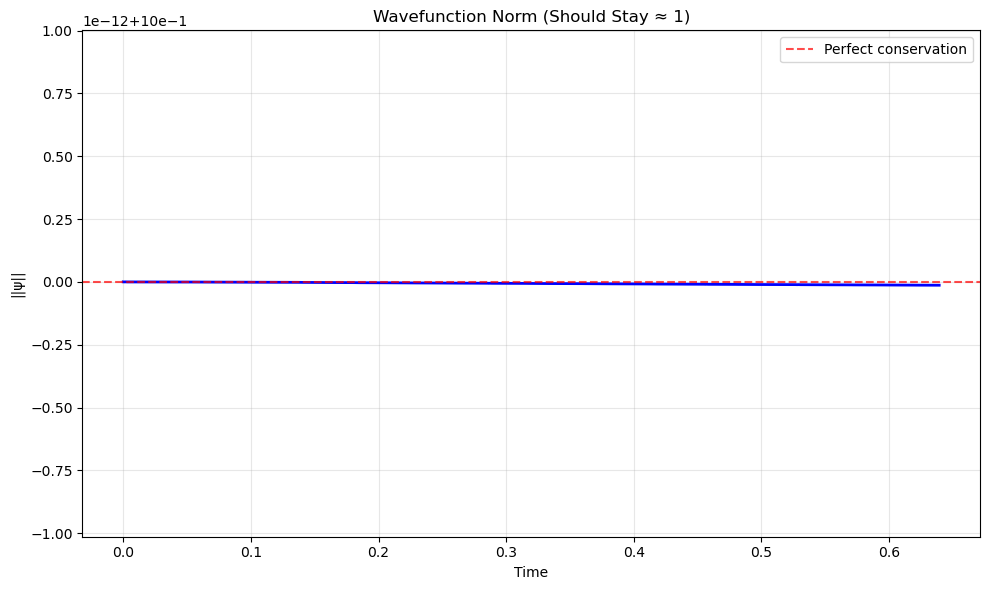

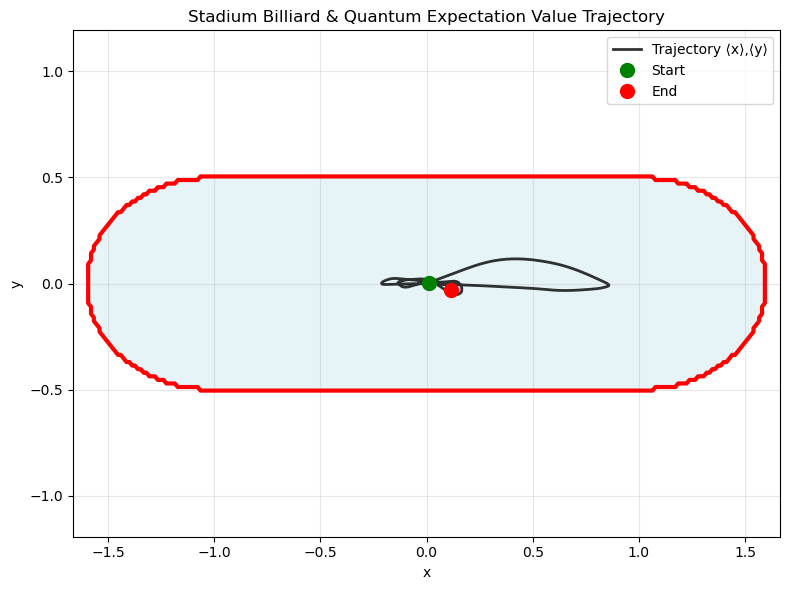

Creating animation...
Saving animation as GIF...
Animation saved as 'quantum_stadium.gif'


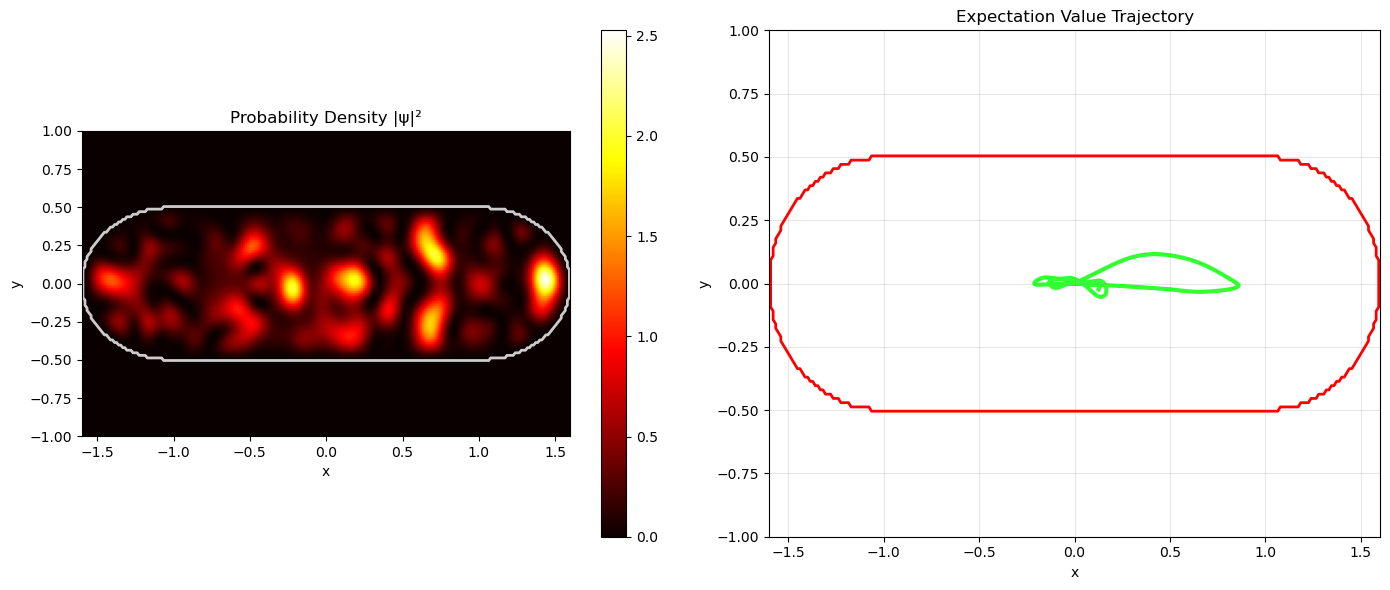


Simulation Results:
- Final norm: 1.0000 (should be ≈ 1.0)
- Norm drift: 0.00%
- Total bounces observed in trajectory
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 240, 120  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = 0.0, 0.0
px0, py0 = 8.0, 3.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry
plt.figure(figsize=(8, 6))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Trajectory ⟨x⟩,⟨y⟩')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=10, label='End')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard & Quantum Expectation Value Trajectory")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Animate the wavefunction evolution
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory buildup
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8)
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Expectation Value Trajectory")
ax2.grid(True, alpha=0.3)

def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update trajectory (up to current frame)
    end_idx = min(frame_idx * 8, len(expect_x))  # Match frame sampling
    line2.set_data(expect_x[:end_idx], expect_y[:end_idx])
    
    return [im1, line2]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

# Save as GIF or MP4 to see the animation
# ani.save('quantum_stadium.gif', writer='pillow', fps=10)
# ani.save('quantum_stadium.mp4', writer='ffmpeg', fps=10)

plt.tight_layout()

# For interactive environments, try this instead of plt.show():
# Fallback: save animation and show static plot
print("Saving animation as GIF...")
ani.save('quantum_stadium.gif', writer='pillow', fps=5, dpi=200)
print("Animation saved as 'quantum_stadium.gif'")
plt.show()  # Shows the last frame

print(f"""
Simulation Results:
- Final norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Total bounces observed in trajectory
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
""")

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Starting simulation...
Step 0/800, norm = 1.0000
Step 100/800, norm = 1.0000
Step 200/800, norm = 1.0000
Step 300/800, norm = 1.0000
Step 400/800, norm = 1.0000
Step 500/800, norm = 1.0000
Step 600/800, norm = 1.0000
Step 700/800, norm = 1.0000
Simulation complete!


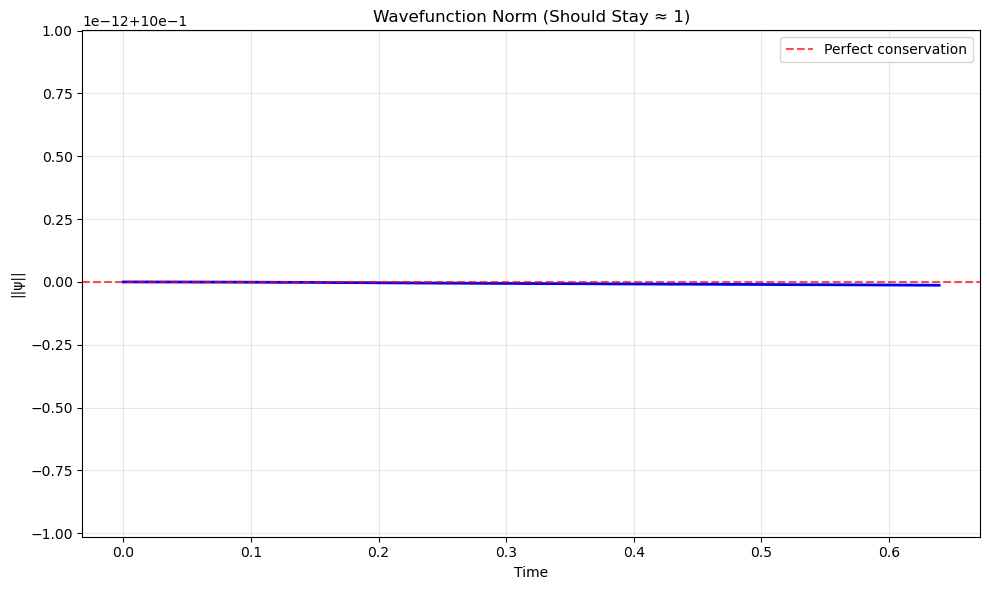

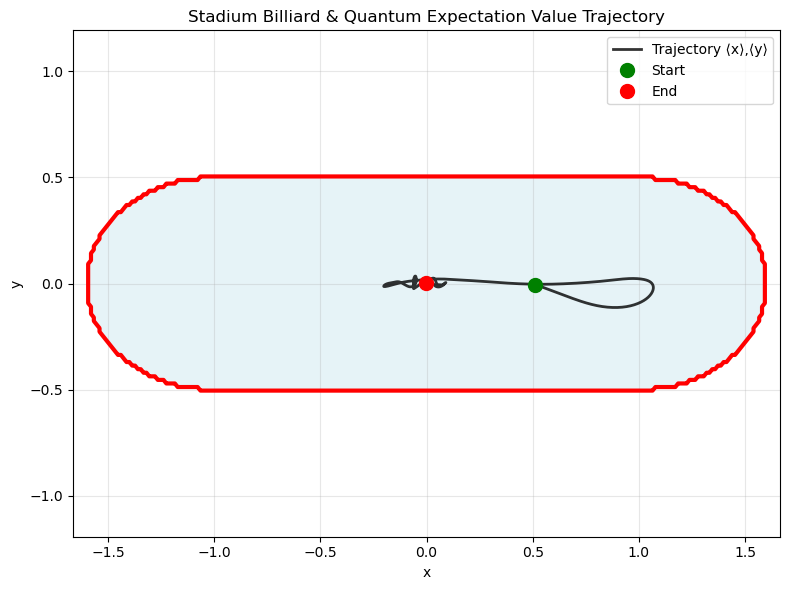

Creating animation...
Saving animation as GIF...
Animation saved as 'quantum_stadium2.gif'


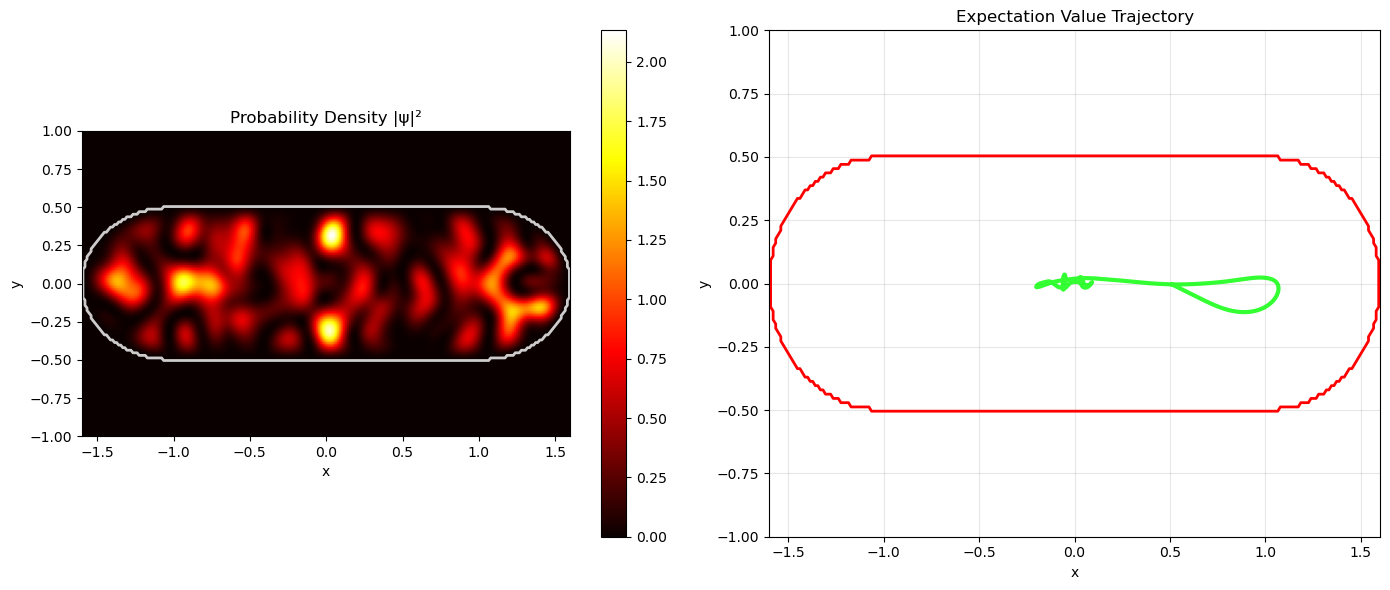


Simulation Results:
- Final norm: 1.0000 (should be ≈ 1.0)
- Norm drift: 0.00%
- Total bounces observed in trajectory
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 240, 120  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = 0.5, 0.0
px0, py0 = 8.0, -3.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry
plt.figure(figsize=(8, 6))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Trajectory ⟨x⟩,⟨y⟩')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=10, label='End')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard & Quantum Expectation Value Trajectory")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Animate the wavefunction evolution
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory buildup
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8)
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Expectation Value Trajectory")
ax2.grid(True, alpha=0.3)

def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update trajectory (up to current frame)
    end_idx = min(frame_idx * 8, len(expect_x))  # Match frame sampling
    line2.set_data(expect_x[:end_idx], expect_y[:end_idx])
    
    return [im1, line2]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

# Save as GIF or MP4 to see the animation
# ani.save('quantum_stadium.gif', writer='pillow', fps=10)
# ani.save('quantum_stadium.mp4', writer='ffmpeg', fps=10)

plt.tight_layout()

# For interactive environments, try this instead of plt.show():
# Fallback: save animation and show static plot
print("Saving animation as GIF...")
ani.save('quantum_stadium2.gif', writer='pillow', fps=5, dpi=200)
print("Animation saved as 'quantum_stadium2.gif'")
plt.show()  # Shows the last frame

print(f"""
Simulation Results:
- Final norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Total bounces observed in trajectory
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
""")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

def classical_trajectory(x0, y0, vx0, vy0, a, b, rx, ry, dt, nsteps):
    """
    Simulate classical particle trajectory in stadium with elastic collisions
    """
    trajectory_x = [x0]
    trajectory_y = [y0]
    
    x, y = x0, y0
    vx, vy = vx0, vy0
    
    for _ in range(nsteps):
        # Move particle
        x_new = x + vx * dt
        y_new = y + vy * dt
        
        # Check for collisions and reflect
        # Straight walls (left/right)
        if x_new < -a - rx or x_new > a + rx:
            vx = -vx
            x_new = x + vx * dt
        
        # Top/bottom walls in rectangular section
        if -a <= x_new <= a and (y_new < -b or y_new > b):
            vy = -vy
            y_new = y + vy * dt
        
        # Curved walls (elliptical ends)
        if x_new > a:
            # Right ellipse: (x-a)²/rx² + y²/ry² = 1
            if ((x_new - a)**2)/(rx**2) + (y_new**2)/(ry**2) > 1.0:
                # Reflect off ellipse
                # Normal vector at collision point
                nx = 2*(x_new - a)/(rx**2)
                ny = 2*y_new/(ry**2)
                norm = np.sqrt(nx**2 + ny**2)
                nx, ny = nx/norm, ny/norm
                
                # Reflect velocity: v' = v - 2(v·n)n
                dot = vx*nx + vy*ny
                vx = vx - 2*dot*nx
                vy = vy - 2*dot*ny
                x_new = x + vx * dt
                y_new = y + vy * dt
                
        elif x_new < -a:
            # Left ellipse: (x+a)²/rx² + y²/ry² = 1
            if ((x_new + a)**2)/(rx**2) + (y_new**2)/(ry**2) > 1.0:
                # Normal vector at collision point
                nx = 2*(x_new + a)/(rx**2)
                ny = 2*y_new/(ry**2)
                norm = np.sqrt(nx**2 + ny**2)
                nx, ny = nx/norm, ny/norm
                
                # Reflect velocity
                dot = vx*nx + vy*ny
                vx = vx - 2*dot*nx
                vy = vy - 2*dot*ny
                x_new = x + vx * dt
                y_new = y + vy * dt
        
        x, y = x_new, y_new
        trajectory_x.append(x)
        trajectory_y.append(y)
    
    return np.array(trajectory_x), np.array(trajectory_y)

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 240, 120  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = 0.5, 0.0
px0, py0 = 50.0, 60.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Simulation complete!")

# Compute classical trajectory
print("Computing classical trajectory...")
# Use same initial position and convert quantum momentum to classical velocity
classical_x, classical_y = classical_trajectory(x0, y0, px0, py0, a, b, rx, ry, dt, nsteps)

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry
plt.figure(figsize=(8, 6))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
plt.plot(classical_x, classical_y, 'orange', linewidth=1.5, alpha=0.9, label='Classical trajectory')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=10, label='End')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard & Quantum Expectation Value Trajectory")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Animate the wavefunction evolution
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory buildup
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8)
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Expectation Value Trajectory")
ax2.grid(True, alpha=0.3)

# Add classical trajectory line if you want it in animation
# (You'll need to add this line after creating line2)
line3, = ax2.plot([], [], 'orange', linewidth=1.5, alpha=0.7, label='Classical')


def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update trajectory (up to current frame)
    end_idx = min(frame_idx * 8, len(expect_x))  # Match frame sampling
    line2.set_data(expect_x[:end_idx], expect_y[:end_idx])
    # Then in animate function:
    line3.set_data(classical_x[:end_idx], classical_y[:end_idx])
    return [im1, line2, line3]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

# Save as GIF or MP4 to see the animation
# ani.save('quantum_stadium.gif', writer='pillow', fps=10)
# ani.save('quantum_stadium.mp4', writer='ffmpeg', fps=10)

plt.tight_layout()

# For interactive environments, try this instead of plt.show():
# Fallback: save animation and show static plot
print("Saving animation as GIF...")
ani.save('quantum_stadium3.gif', writer='pillow', fps=5, dpi=200)
print("Animation saved as 'quantum_stadium3.gif'")
plt.show()  # Shows the last frame

print(f"""
Simulation Results:
- Final norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Total bounces observed in trajectory
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}    
""")

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


: 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity
from scipy.sparse.linalg import spsolve

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 240, 120
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket
x0, y0 = 0.5, 0.0
px0, py0 = 50.0, 60.0
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2

Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)
L2D = L2D.tocsc()

# Apply stadium boundary conditions
mask_flat = mask.flatten()
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008
I = identity(Nx*Ny)
A = (I - 0.5j*dt*L2D).tocsc()
B = (I + 0.5j*dt*L2D).tocsc()

# ----------------------------
# Classical trajectory setup
# ----------------------------
def stadium_normal(x, y, a, b, rx, ry):
    if abs(x) <= a and abs(y) >= b:  # flat top/bottom
        return np.array([0, np.sign(y)])
    elif x > a:  # right semicircle
        nx = (x - a) / (rx**2)
        ny = y / (ry**2)
        v = np.array([nx, ny])
        return v / np.linalg.norm(v)
    elif x < -a:  # left semicircle
        nx = (x + a) / (rx**2)
        ny = y / (ry**2)
        v = np.array([nx, ny])
        return v / np.linalg.norm(v)
    else:  # vertical walls
        return np.array([np.sign(x), 0])

def reflect_if_outside(xc, yc, vx, vy, a, b, rx, ry):
    if is_inside_stadium(xc, yc, a, b, rx, ry):
        return xc, yc, vx, vy
    # Move back until inside
    for _ in range(10):
        xc -= 0.1*vx*dt
        yc -= 0.1*vy*dt
        if is_inside_stadium(xc, yc, a, b, rx, ry):
            break
    # Reflect
    n = stadium_normal(xc, yc, a, b, rx, ry)
    v = np.array([vx, vy])
    v_ref = v - 2*np.dot(v, n)*n
    return xc, yc, v_ref[0], v_ref[1]

# Classical initial conditions
xc, yc = x0, y0
vx, vy = px0, py0
classical_x, classical_y = [xc], [yc]

# ----------------------------
# Live Animation
# ----------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Left: probability density
psi = psi0.flatten().copy()
im1 = ax1.imshow(np.abs(psi.reshape(Nx,Ny).T)**2,
                extent=[x[0], x[-1], y[0], y[-1]],
                origin='lower', cmap='hot', vmin=0, vmax=1)
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2)
ax1.set_title("Probability Density |ψ|²")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right: trajectories
line_q, = ax2.plot([], [], 'lime', linewidth=2, label="Quantum ⟨x⟩,⟨y⟩")
line_c, = ax2.plot([], [], 'r--', linewidth=2, label="Classical")
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='black', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Quantum vs Classical Trajectories")
ax2.legend()

quantum_x, quantum_y = [], []

def animate(frame_idx):
    global psi, xc, yc, vx, vy
    
    # --- Quantum evolution ---
    psi = spsolve(A, B @ psi)
    psi[~mask_flat] = 0.0
    psi2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi2d)**2
    
    # expectation values
    norm = np.sum(prob_density)*dx*dy
    ex = np.sum(prob_density * X)*dx*dy / norm
    ey = np.sum(prob_density * Y)*dx*dy / norm
    quantum_x.append(ex)
    quantum_y.append(ey)
    
    im1.set_array(prob_density.T)
    im1.set_clim(0, np.max(prob_density))
    
    # --- Classical evolution ---
    xc += vx*dt
    yc += vy*dt
    xc, yc, vx, vy = reflect_if_outside(xc, yc, vx, vy, a, b, rx, ry)
    classical_x.append(xc)
    classical_y.append(yc)
    
    # update trajectory plots
    line_q.set_data(quantum_x, quantum_y)
    line_c.set_data(classical_x, classical_y)
    
    return [im1, line_q, line_c]

nsteps = 800
ani = FuncAnimation(fig, animate, frames=nsteps, interval=30, blit=False, repeat=False)

# Save to file
ani.save("quantum_vs_classical.mp4", writer="ffmpeg", fps=8, dpi=200)

plt.tight_layout()
plt.show()

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Starting quantum simulation...
Step 0/300, norm = 1.0000
Step 50/300, norm = 1.0000
Step 100/300, norm = 1.0000
Step 150/300, norm = 1.0000
Step 200/300, norm = 1.0000
Step 250/300, norm = 1.0000
Quantum simulation complete!
Computing classical trajectory...
Classical simulation complete!


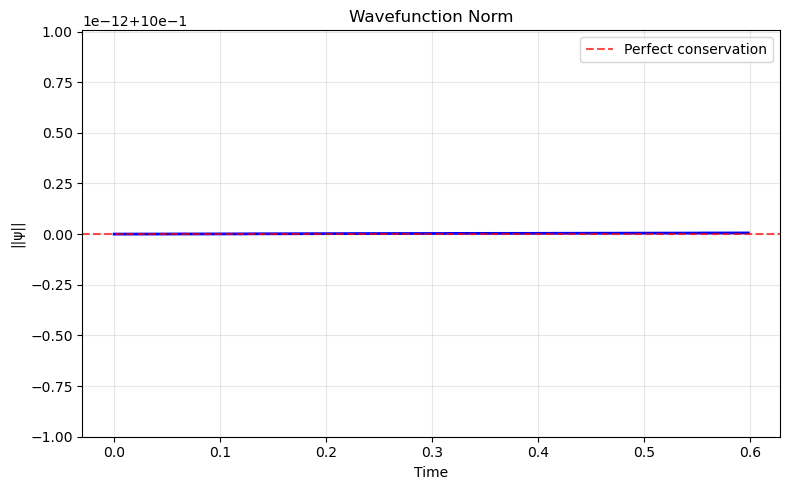

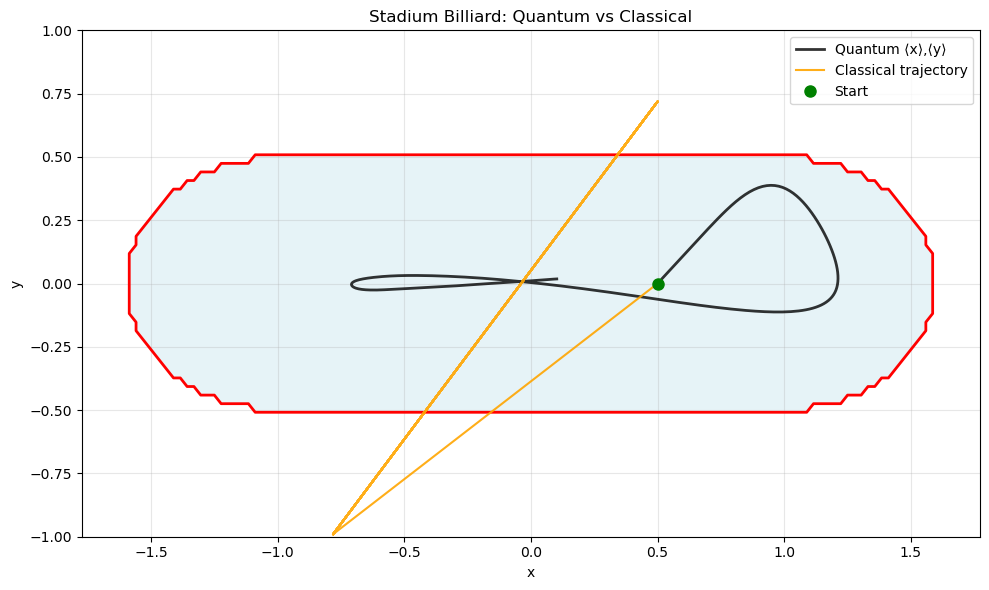

Creating simple animation...


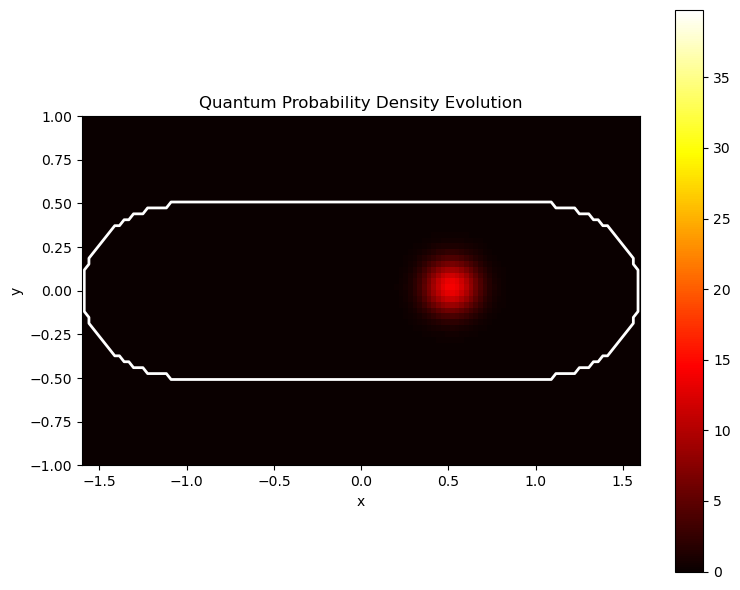


Simulation Results:
- Final quantum norm: 1.0000
- Norm drift: 0.00%
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5
- Total time: 0.5980
- Grid size: 120x60
- Quantum steps: 300
- Classical points: 14



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Simple classical trajectory (lightweight)
# ----------------------------
def simple_classical_trajectory(x0, y0, vx0, vy0, a, b, rx, ry, dt, total_time):
    """Simplified classical trajectory with basic collision detection"""
    n_points = int(total_time / (dt * 20))  # Much fewer points
    dt_classical = total_time / n_points
    
    trajectory_x = np.zeros(n_points)
    trajectory_y = np.zeros(n_points)
    
    x, y = x0, y0
    vx, vy = vx0, vy0
    
    trajectory_x[0] = x
    trajectory_y[0] = y
    
    for i in range(1, n_points):
        # Simple Euler step with collision handling
        x_new = x + vx * dt_classical
        y_new = y + vy * dt_classical
        
        # Basic boundary checks and reflections
        # Vertical walls
        if x_new <= -a - rx or x_new >= a + rx:
            vx = -vx
            x_new = x + vx * dt_classical
        
        # Horizontal walls in rectangular section
        if -a <= x_new <= a and (y_new <= -b or y_new >= b):
            vy = -vy
            y_new = y + vy * dt_classical
        
        # Elliptical boundaries (simplified)
        if x_new > a:
            dist_sq = ((x_new - a)**2)/(rx**2) + (y_new**2)/(ry**2)
            if dist_sq > 1.0:
                # Simple reflection - reverse both components
                vx = -abs(vx)  # Point leftward
                if y_new > 0:
                    vy = -abs(vy)
                else:
                    vy = abs(vy)
                x_new = x + vx * dt_classical
                y_new = y + vy * dt_classical
        elif x_new < -a:
            dist_sq = ((x_new + a)**2)/(rx**2) + (y_new**2)/(ry**2)
            if dist_sq > 1.0:
                # Simple reflection
                vx = abs(vx)  # Point rightward
                if y_new > 0:
                    vy = -abs(vy)
                else:
                    vy = abs(vy)
                x_new = x + vx * dt_classical
                y_new = y + vy * dt_classical
        
        # Safety: keep inside bounds
        x_new = np.clip(x_new, -a-rx+0.01, a+rx-0.01)
        y_new = np.clip(y_new, -b-ry+0.01, b+ry-0.01)
        
        x, y = x_new, y_new
        trajectory_x[i] = x
        trajectory_y[i] = y
    
    return trajectory_x, trajectory_y

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters (REDUCED for stability)
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 120, 60  # Further reduced grid
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket
x0, y0 = 0.5, 0.0
px0, py0 = 30.0, 40.0  # Reduced momentum for stability
sigma = 0.15
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Boundary conditions
Lx = Lx.tolil()
Lx[0, 0] = -1/hx
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.002  # Larger timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution (REDUCED steps)
# ----------------------------
psi = psi0.flatten()
nsteps = 300  # Much fewer steps
norms = []
expect_x = []
expect_y = []
frames = []
times = []

print("Starting quantum simulation...")

for step in range(nsteps):
    psi = spsolve(A, B @ psi)
    psi[~mask_flat] = 0.0

    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    times.append(step * dt)
    
    # Store fewer frames
    if step % 15 == 0:
        frames.append(prob_density.copy())
    
    if step % 50 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Quantum simulation complete!")

# Compute classical trajectory (lightweight)
print("Computing classical trajectory...")
total_time = times[-1]
classical_x, classical_y = simple_classical_trajectory(x0, y0, px0, py0, a, b, rx, ry, dt, total_time)
print("Classical simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(8, 5))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Stadium geometry with trajectories
plt.figure(figsize=(10, 6))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'black', linewidth=2, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
plt.plot(classical_x, classical_y, 'orange', linewidth=1.5, alpha=0.9, label='Classical trajectory')
plt.plot(x0, y0, 'go', markersize=8, label='Start')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard: Quantum vs Classical")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Simple animation (no complex features to avoid crashes)
print("Creating simple animation...")

fig, ax = plt.subplots(figsize=(8, 6))

# Just show the probability density evolution
im = ax.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
               origin='lower', cmap='hot', vmin=0, vmax=np.max(frames))
ax.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Quantum Probability Density Evolution")
plt.colorbar(im)

def animate_simple(frame_idx):
    im.set_array(frames[frame_idx].T)
    im.set_clim(0, np.max(frames[frame_idx]))
    return [im]

# Minimal animation
ani = FuncAnimation(fig, animate_simple, frames=len(frames), 
                   interval=200, blit=False, repeat=True)

plt.tight_layout()
plt.show()

print(f"""
Simulation Results:
- Final quantum norm: {norms[-1]:.4f}
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
- Total time: {total_time:.4f}
- Grid size: {Nx}x{Ny}
- Quantum steps: {nsteps}
- Classical points: {len(classical_x)}
""")

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Starting quantum simulation...
Step 0/800, norm = 1.0000
Step 100/800, norm = 1.0000
Step 200/800, norm = 1.0000
Step 300/800, norm = 1.0000
Step 400/800, norm = 1.0000
Step 500/800, norm = 1.0000
Step 600/800, norm = 1.0000
Step 700/800, norm = 1.0000
Quantum simulation complete!
Computing classical trajectory...
Classical simulation complete!


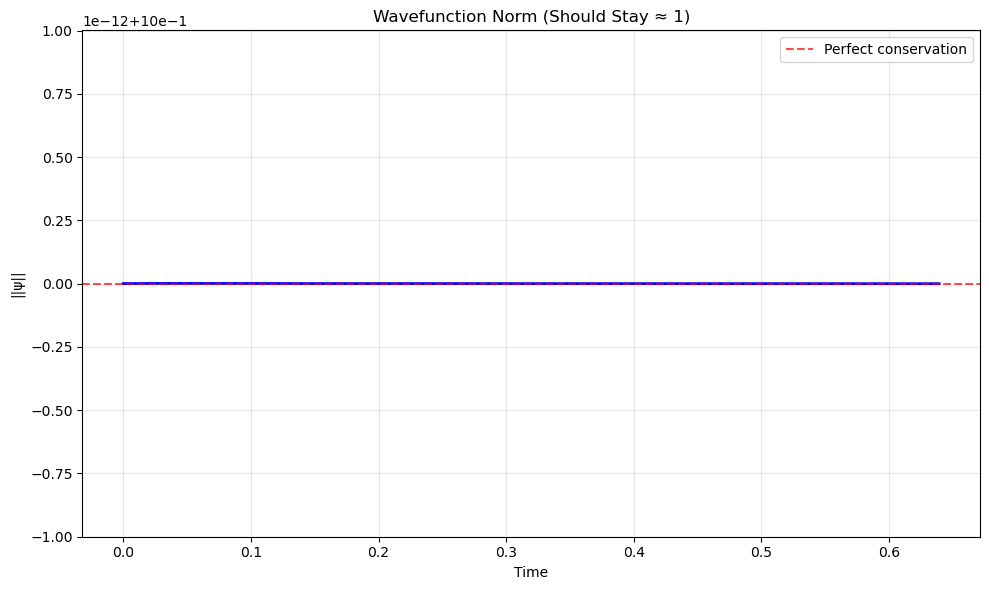

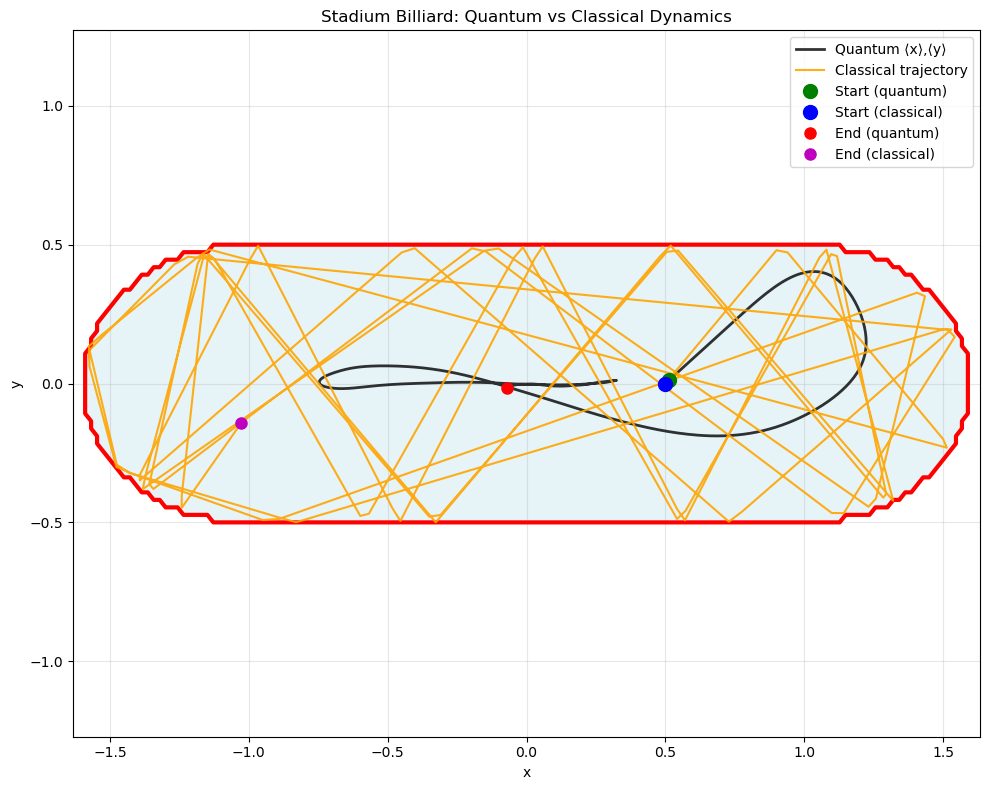

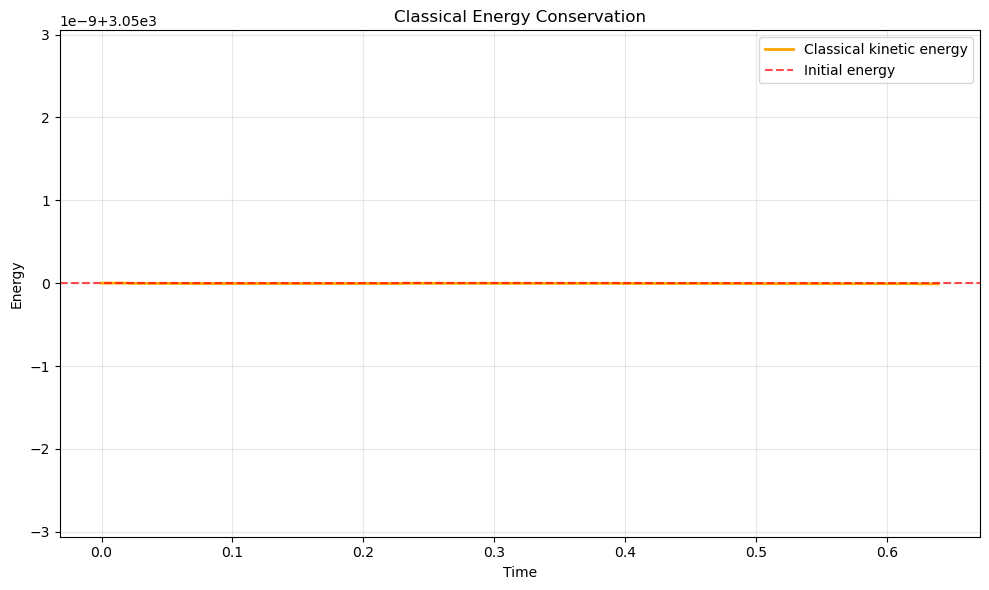

Creating animation...
Saving animation as GIF...
Animation saved as 'quantum_classical_stadium.gif'


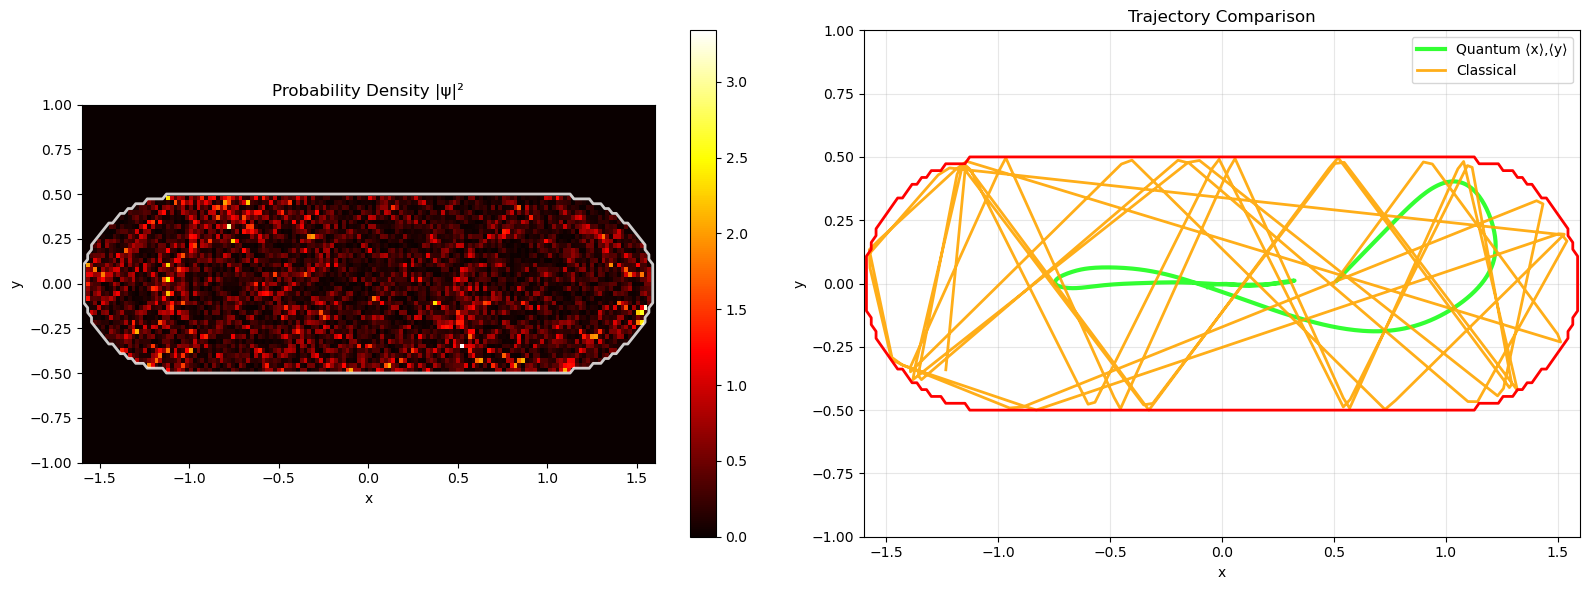


Simulation Results:
- Final quantum norm: 1.0000 (should be ≈ 1.0)
- Norm drift: 0.00%
- Classical energy conservation: 0.0000% drift
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5
- Simulation time: 0.6392
- Classical trajectory points: 800
- Quantum trajectory points: 800



In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve
from math import pi, sqrt, sin, cos
from typing import Tuple

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Classical trajectory functions (from second file)
# ----------------------------
def boundary_normal(x: float, y: float, a: float, b: float, rx: float, ry: float) -> np.ndarray:
    """
    Returns the inward unit normal at a boundary point (x,y).
    """
    eps = 1e-9
    # check top/bottom flats
    if abs(abs(y) - b) < 1e-8 and -a - 1e-8 <= x <= a + 1e-8:
        if y > 0:
            return np.array([0.0, -1.0])  # top -> inward points down
        else:
            return np.array([0.0, 1.0])   # bottom -> inward points up
    
    # check right ellipse
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right - 1.0) < 1e-6 and x >= a - 1e-6:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([-1.0, 0.0])
        return nin / norm
    
    # check left ellipse
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left - 1.0) < 1e-6 and x <= -a + 1e-6:
        gx = 2.0*(x + a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([1.0, 0.0])
        return nin / norm
    
    # fallback
    dtop = abs(y - b)
    dbot = abs(y + b)
    dright = abs(val_right - 1.0)
    dleft = abs(val_left - 1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind == dtop:
        return np.array([0.0, -1.0])
    if mind == dbot:
        return np.array([0.0, 1.0])
    if mind == dright:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        nrm = np.linalg.norm(nin)
        return nin / max(nrm, eps)
    
    gx = 2.0*(x + a)/(rx**2)
    gy = 2.0*y/(ry**2)
    nin = -np.array([gx, gy])
    nrm = np.linalg.norm(nin)
    return nin / max(nrm, eps)

def reflect_velocity(v: np.ndarray, n_inward: np.ndarray) -> np.ndarray:
    """Elastic reflection across boundary with inward normal n_inward (unit)."""
    return v - 2.0 * np.dot(v, n_inward) * n_inward

def find_collision_time_between(x: np.ndarray, v: np.ndarray, dt: float, a: float, b: float, rx: float, ry: float) -> Tuple[bool, float, np.ndarray]:
    """Find collision time using bisection."""
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry):
        return (False, None, None)

    t_lo = 0.0
    t_hi = dt
    
    def inside_at(t):
        pt = x + v*t
        return is_inside_stadium(pt[0], pt[1], a, b, rx, ry)

    if not inside_at(t_lo):
        return (True, 0.0, x.copy())
    if inside_at(t_hi):
        return (False, None, None)

    for _ in range(40):
        tm = 0.5*(t_lo + t_hi)
        if inside_at(tm):
            t_lo = tm
        else:
            t_hi = tm
    
    t_collision = 0.5*(t_lo + t_hi)
    collision_point = x + v * t_collision
    return (True, t_collision, collision_point)

def integrate_particle(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """Integrate single particle with elastic reflections."""
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]

    for step in range(nsteps):
        remaining_dt = dt
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                if tcol < 1e-14:
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v = reflect_velocity(v, n)
                    x = x + v * (1e-8)
                    continue
                
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v = reflect_velocity(v, n)
        
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    
    return np.array(times), np.array(positions), np.array(velocities)

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 150, 75  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = 0.5, 0.0
px0, py0 = 50.0, 60.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting quantum simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Quantum simulation complete!")

# Compute classical trajectory using the robust method from the second file
print("Computing classical trajectory...")
x0_classical = np.array([x0, y0])
v0_classical = np.array([px0, py0])
T_total = times[-1]  # Match quantum simulation time

classical_times, classical_positions, classical_velocities = integrate_particle(
    x0_classical, v0_classical, a, b, rx, ry, dt, T_total)

print("Classical simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry with both trajectories
plt.figure(figsize=(10, 8))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
plt.plot(classical_positions[:, 0], classical_positions[:, 1], 'orange', linewidth=1.5, alpha=0.9, label='Classical trajectory')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start (quantum)')
plt.plot(classical_positions[0, 0], classical_positions[0, 1], 'bo', markersize=10, label='Start (classical)')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=8, label='End (quantum)')
plt.plot(classical_positions[-1, 0], classical_positions[-1, 1], 'mo', markersize=8, label='End (classical)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard: Quantum vs Classical Dynamics")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Energy comparison
plt.figure(figsize=(10, 6))
classical_energies = [0.5 * np.dot(v, v) for v in classical_velocities]
plt.plot(classical_times, classical_energies, 'orange', linewidth=2, label='Classical kinetic energy')
plt.axhline(y=classical_energies[0], color='r', linestyle='--', alpha=0.7, label='Initial energy')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Classical Energy Conservation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Animate the wavefunction evolution with both trajectories
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory comparison
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
line3, = ax2.plot([], [], 'orange', linewidth=2, alpha=0.9, label='Classical')
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Trajectory Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)

def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update quantum trajectory (up to current frame)
    quantum_end_idx = min(frame_idx * 8, len(expect_x))
    line2.set_data(expect_x[:quantum_end_idx], expect_y[:quantum_end_idx])
    
    # Update classical trajectory (match time, not index)
    current_time = quantum_end_idx * dt if quantum_end_idx < len(times) else times[-1]
    classical_mask = classical_times <= current_time
    if np.any(classical_mask):
        classical_subset = classical_positions[classical_mask]
        line3.set_data(classical_subset[:, 0], classical_subset[:, 1])
    
    return [im1, line2, line3]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

plt.tight_layout()

# Save animation
print("Saving animation as GIF...")
ani.save('quantum_classical_stadium.gif', writer='pillow', fps=8, dpi=300)
print("Animation saved as 'quantum_classical_stadium.gif'")
plt.show()

print(f"""
Simulation Results:
- Final quantum norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Classical energy conservation: {abs(classical_energies[-1] - classical_energies[0])/classical_energies[0]*100:.4f}% drift
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
- Simulation time: {T_total:.4f}
- Classical trajectory points: {len(classical_positions)}
- Quantum trajectory points: {len(expect_x)}
""")

/home/nikshaychugh/miniconda3/envs/usualpy_env/lib/python3.11/site-packages/scipy/sparse/_index.py:210: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


Starting quantum simulation...
Step 0/800, norm = 1.0000
Step 100/800, norm = 1.0000
Step 200/800, norm = 1.0000
Step 300/800, norm = 1.0000
Step 400/800, norm = 1.0000
Step 500/800, norm = 1.0000
Step 600/800, norm = 1.0000
Step 700/800, norm = 1.0000
Quantum simulation complete!
Computing classical trajectory...
Classical simulation complete!


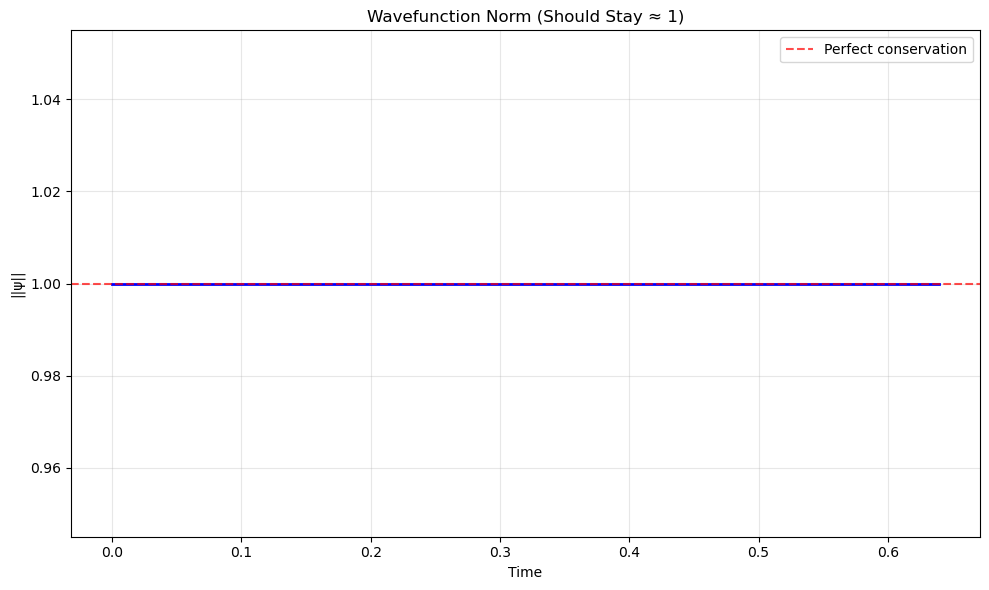

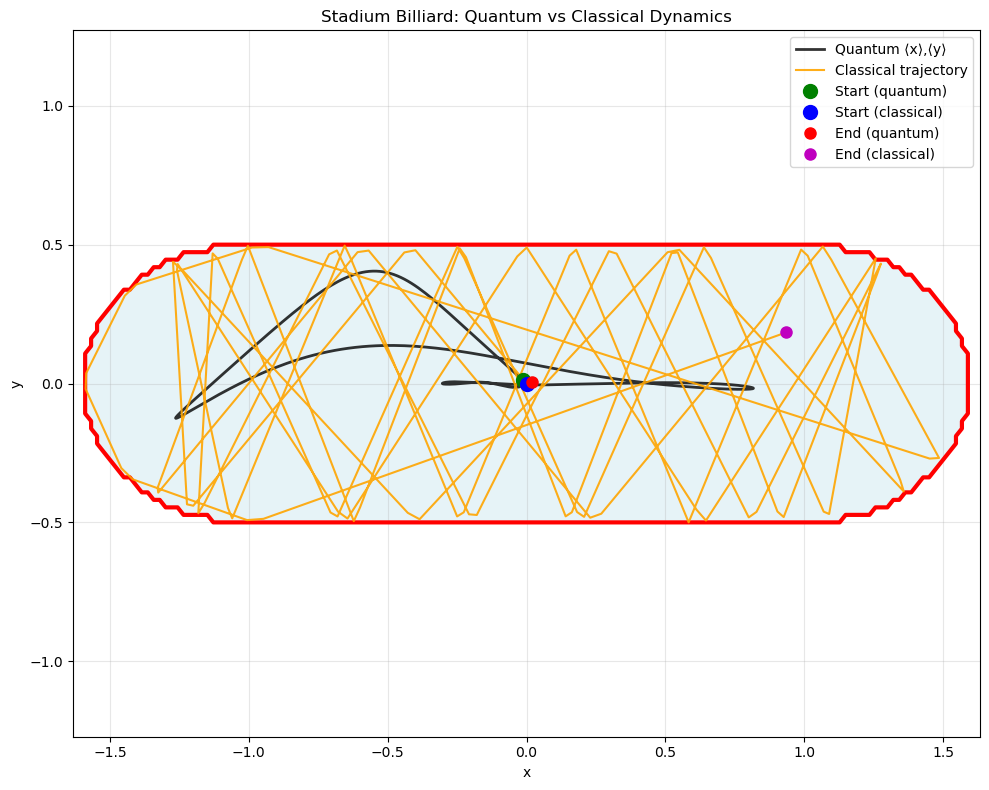

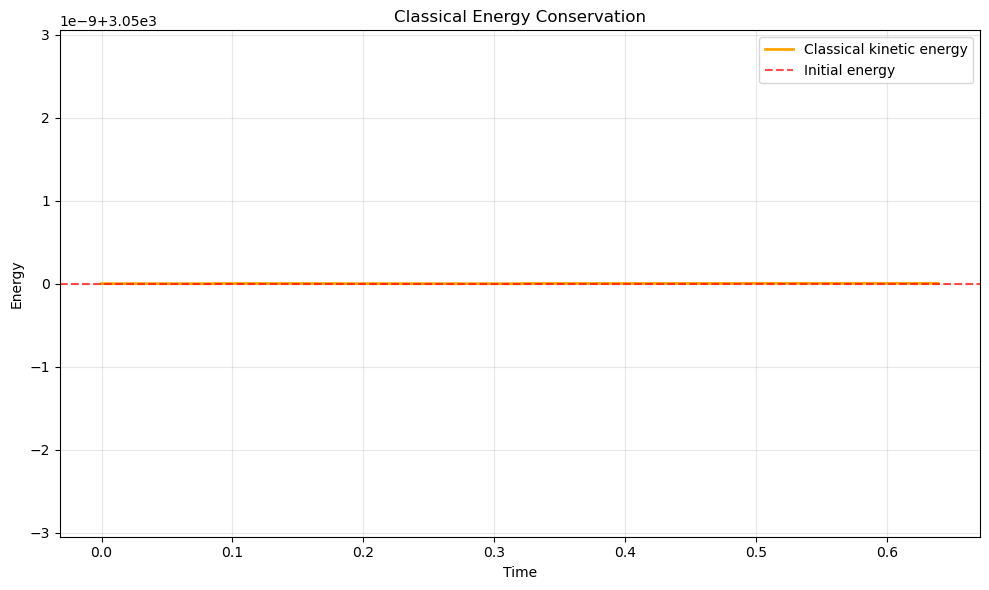

Creating animation...
Saving animation as GIF...
Animation saved as 'quantum_classical_stadium2.gif'


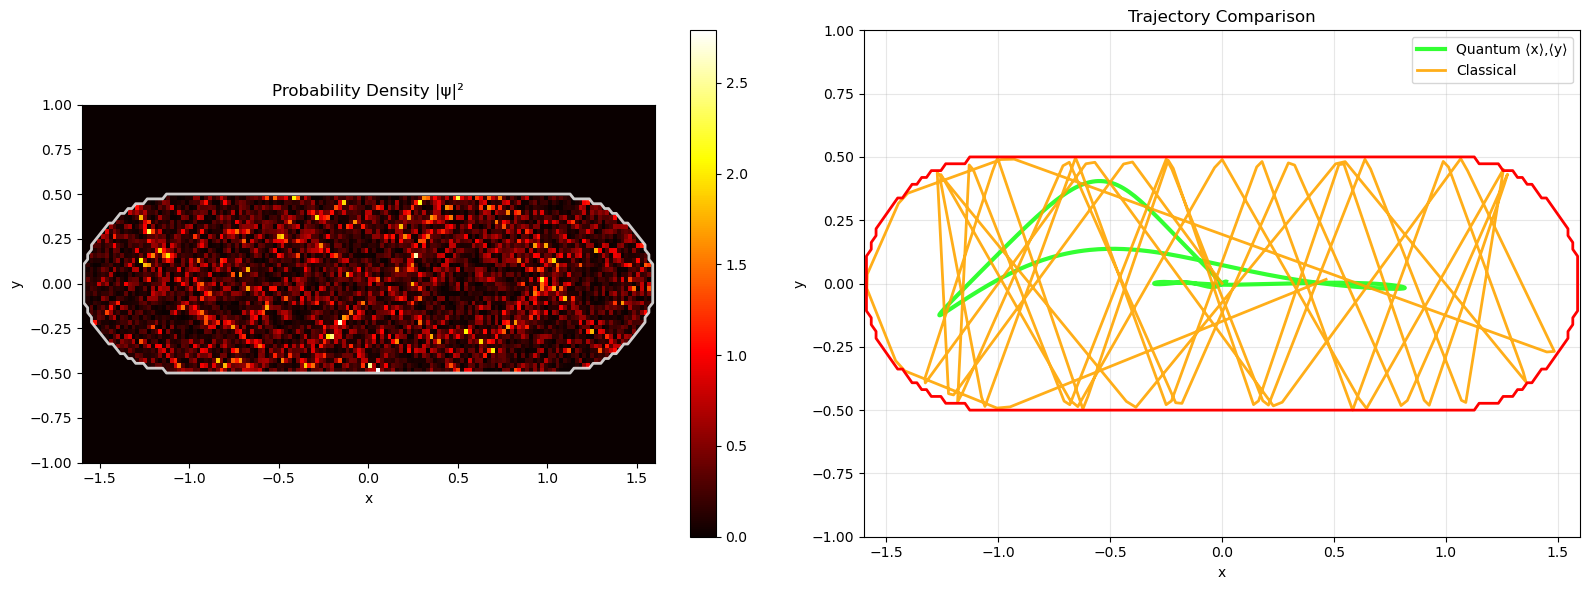


Simulation Results:
- Final quantum norm: 1.0000 (should be ≈ 1.0)
- Norm drift: 0.00%
- Classical energy conservation: 0.0000% drift
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5
- Simulation time: 0.6392
- Classical trajectory points: 800
- Quantum trajectory points: 800



In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve
from math import pi, sqrt, sin, cos
from typing import Tuple

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Classical trajectory functions (from second file)
# ----------------------------
def boundary_normal(x: float, y: float, a: float, b: float, rx: float, ry: float) -> np.ndarray:
    """
    Returns the inward unit normal at a boundary point (x,y).
    """
    eps = 1e-9
    # check top/bottom flats
    if abs(abs(y) - b) < 1e-8 and -a - 1e-8 <= x <= a + 1e-8:
        if y > 0:
            return np.array([0.0, -1.0])  # top -> inward points down
        else:
            return np.array([0.0, 1.0])   # bottom -> inward points up
    
    # check right ellipse
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right - 1.0) < 1e-6 and x >= a - 1e-6:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([-1.0, 0.0])
        return nin / norm
    
    # check left ellipse
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left - 1.0) < 1e-6 and x <= -a + 1e-6:
        gx = 2.0*(x + a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([1.0, 0.0])
        return nin / norm
    
    # fallback
    dtop = abs(y - b)
    dbot = abs(y + b)
    dright = abs(val_right - 1.0)
    dleft = abs(val_left - 1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind == dtop:
        return np.array([0.0, -1.0])
    if mind == dbot:
        return np.array([0.0, 1.0])
    if mind == dright:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        nrm = np.linalg.norm(nin)
        return nin / max(nrm, eps)
    
    gx = 2.0*(x + a)/(rx**2)
    gy = 2.0*y/(ry**2)
    nin = -np.array([gx, gy])
    nrm = np.linalg.norm(nin)
    return nin / max(nrm, eps)

def reflect_velocity(v: np.ndarray, n_inward: np.ndarray) -> np.ndarray:
    """Elastic reflection across boundary with inward normal n_inward (unit)."""
    return v - 2.0 * np.dot(v, n_inward) * n_inward

def find_collision_time_between(x: np.ndarray, v: np.ndarray, dt: float, a: float, b: float, rx: float, ry: float) -> Tuple[bool, float, np.ndarray]:
    """Find collision time using bisection."""
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry):
        return (False, None, None)

    t_lo = 0.0
    t_hi = dt
    
    def inside_at(t):
        pt = x + v*t
        return is_inside_stadium(pt[0], pt[1], a, b, rx, ry)

    if not inside_at(t_lo):
        return (True, 0.0, x.copy())
    if inside_at(t_hi):
        return (False, None, None)

    for _ in range(40):
        tm = 0.5*(t_lo + t_hi)
        if inside_at(tm):
            t_lo = tm
        else:
            t_hi = tm
    
    t_collision = 0.5*(t_lo + t_hi)
    collision_point = x + v * t_collision
    return (True, t_collision, collision_point)

def integrate_particle(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """Integrate single particle with elastic reflections."""
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]

    for step in range(nsteps):
        remaining_dt = dt
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                if tcol < 1e-14:
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v = reflect_velocity(v, n)
                    x = x + v * (1e-8)
                    continue
                
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v = reflect_velocity(v, n)
        
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    
    return np.array(times), np.array(positions), np.array(velocities)

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 150, 75  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = 0.0, 0.0
px0, py0 = -50.0, 60.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting quantum simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Quantum simulation complete!")

# Compute classical trajectory using the robust method from the second file
print("Computing classical trajectory...")
x0_classical = np.array([x0, y0])
v0_classical = np.array([px0, py0])
T_total = times[-1]  # Match quantum simulation time

classical_times, classical_positions, classical_velocities = integrate_particle(
    x0_classical, v0_classical, a, b, rx, ry, dt, T_total)

print("Classical simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry with both trajectories
plt.figure(figsize=(10, 8))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
plt.plot(classical_positions[:, 0], classical_positions[:, 1], 'orange', linewidth=1.5, alpha=0.9, label='Classical trajectory')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start (quantum)')
plt.plot(classical_positions[0, 0], classical_positions[0, 1], 'bo', markersize=10, label='Start (classical)')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=8, label='End (quantum)')
plt.plot(classical_positions[-1, 0], classical_positions[-1, 1], 'mo', markersize=8, label='End (classical)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard: Quantum vs Classical Dynamics")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Energy comparison
plt.figure(figsize=(10, 6))
classical_energies = [0.5 * np.dot(v, v) for v in classical_velocities]
plt.plot(classical_times, classical_energies, 'orange', linewidth=2, label='Classical kinetic energy')
plt.axhline(y=classical_energies[0], color='r', linestyle='--', alpha=0.7, label='Initial energy')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Classical Energy Conservation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Animate the wavefunction evolution with both trajectories
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory comparison
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
line3, = ax2.plot([], [], 'orange', linewidth=2, alpha=0.9, label='Classical')
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Trajectory Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)

def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update quantum trajectory (up to current frame)
    quantum_end_idx = min(frame_idx * 8, len(expect_x))
    line2.set_data(expect_x[:quantum_end_idx], expect_y[:quantum_end_idx])
    
    # Update classical trajectory (match time, not index)
    current_time = quantum_end_idx * dt if quantum_end_idx < len(times) else times[-1]
    classical_mask = classical_times <= current_time
    if np.any(classical_mask):
        classical_subset = classical_positions[classical_mask]
        line3.set_data(classical_subset[:, 0], classical_subset[:, 1])
    
    return [im1, line2, line3]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

plt.tight_layout()

# Save animation
print("Saving animation as GIF...")
ani.save('quantum_classical_stadium2.gif', writer='pillow', fps=8, dpi=300)
print("Animation saved as 'quantum_classical_stadium2.gif'")
plt.show()

print(f"""
Simulation Results:
- Final quantum norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Classical energy conservation: {abs(classical_energies[-1] - classical_energies[0])/classical_energies[0]*100:.4f}% drift
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
- Simulation time: {T_total:.4f}
- Classical trajectory points: {len(classical_positions)}
- Quantum trajectory points: {len(expect_x)}
""")

Starting quantum simulation...
Step 0/800, norm = 1.0000
Step 100/800, norm = 1.0000
Step 200/800, norm = 1.0000
Step 300/800, norm = 1.0000
Step 400/800, norm = 1.0000
Step 500/800, norm = 1.0000
Step 600/800, norm = 1.0000
Step 700/800, norm = 1.0000
Quantum simulation complete!
Computing classical trajectory...
Classical simulation complete!


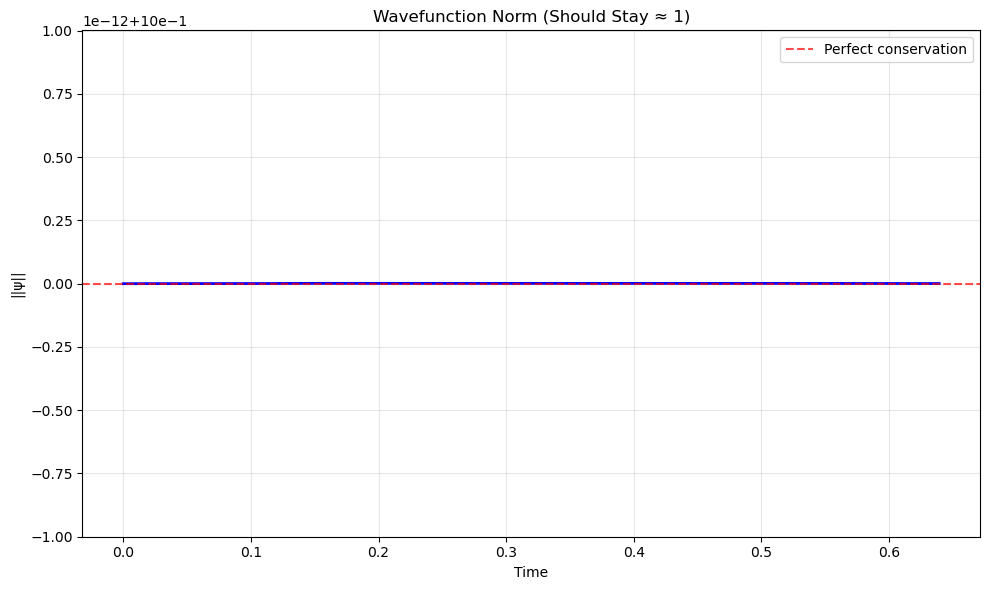

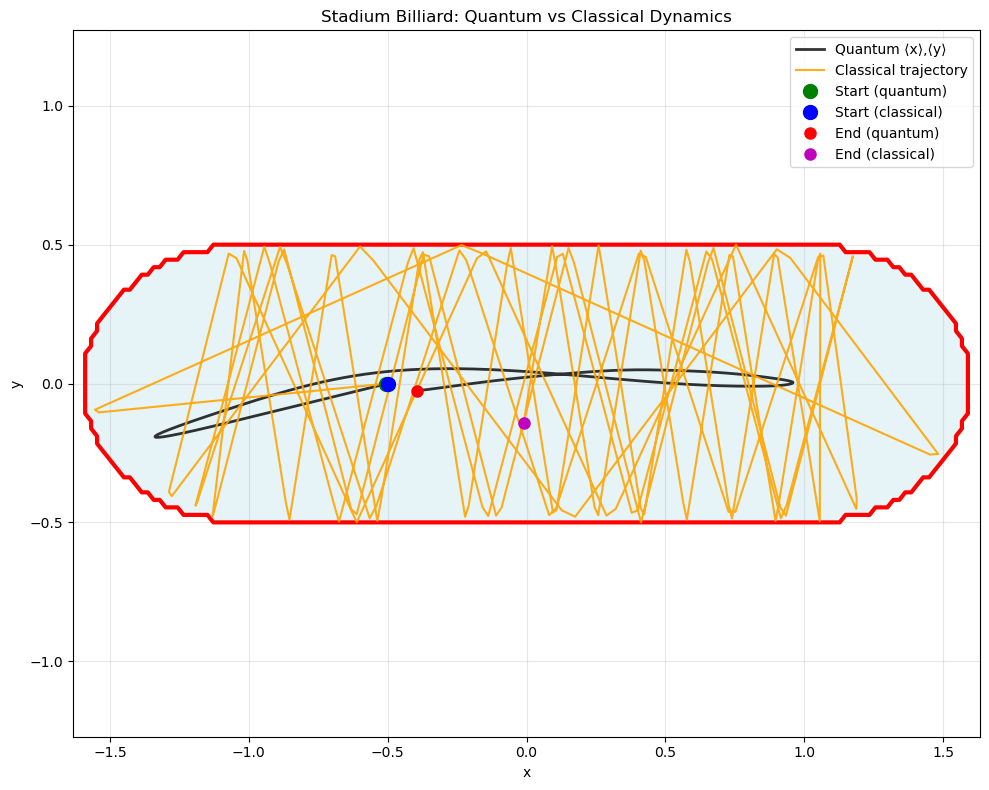

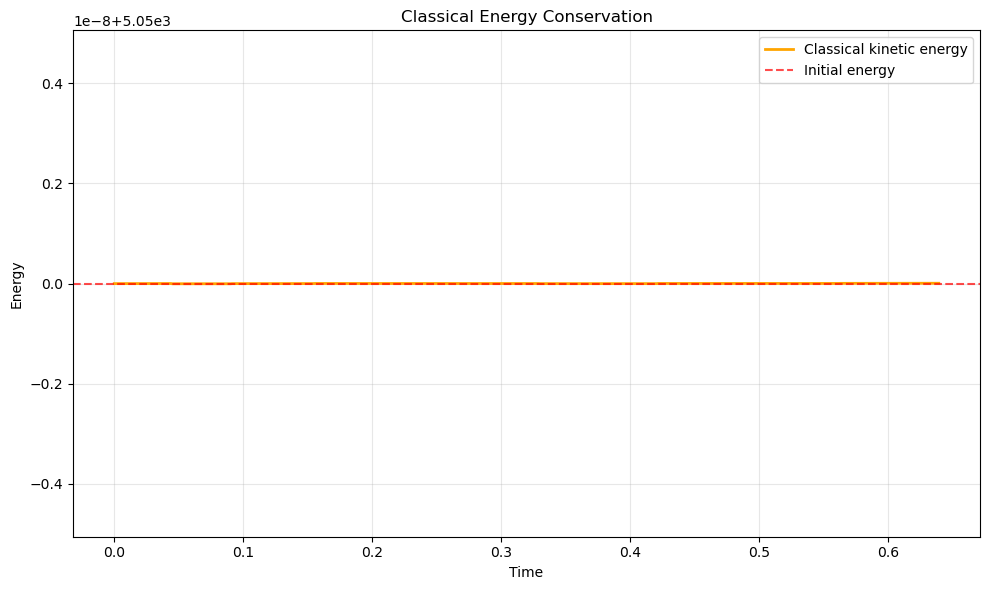

Creating animation...
Saving animation as GIF...
Animation saved as 'quantum_classical_stadium3.gif'


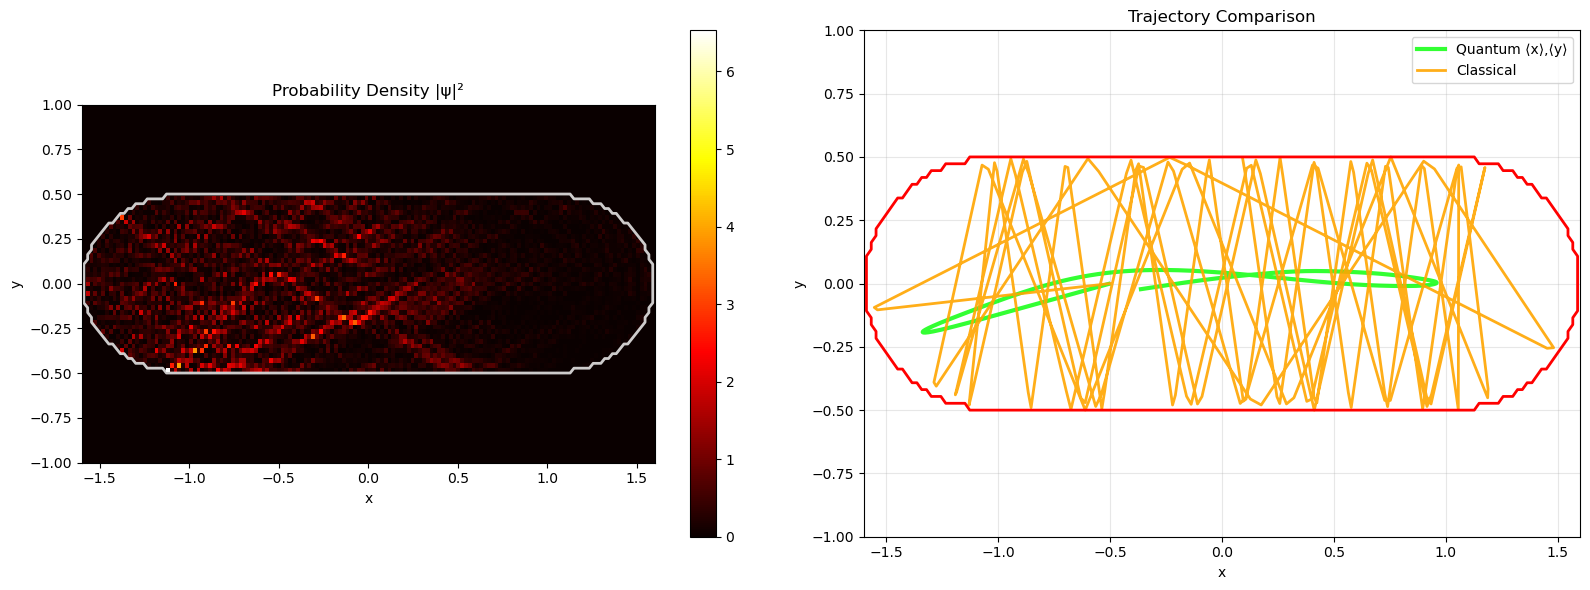


Simulation Results:
- Final quantum norm: 1.0000 (should be ≈ 1.0)
- Norm drift: 0.00%
- Classical energy conservation: 0.0000% drift
- Stadium dimensions: a=1.0, b=0.5, rx=0.6, ry=0.5
- Simulation time: 0.6392
- Classical trajectory points: 800
- Quantum trajectory points: 800



In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, kron, identity, csc_matrix
from scipy.sparse.linalg import spsolve
from math import pi, sqrt, sin, cos
from typing import Tuple

# ----------------------------
# Define stadium geometry
# ----------------------------
def is_inside_stadium(x, y, a, b, rx, ry):
    if -a <= x <= a:
        return abs(y) <= b
    elif x > a:
        return ((x - a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0
    else:  # x < -a
        return ((x + a)**2)/(rx**2) + (y**2)/(ry**2) <= 1.0

# ----------------------------
# Classical trajectory functions (from second file)
# ----------------------------
def boundary_normal(x: float, y: float, a: float, b: float, rx: float, ry: float) -> np.ndarray:
    """
    Returns the inward unit normal at a boundary point (x,y).
    """
    eps = 1e-9
    # check top/bottom flats
    if abs(abs(y) - b) < 1e-8 and -a - 1e-8 <= x <= a + 1e-8:
        if y > 0:
            return np.array([0.0, -1.0])  # top -> inward points down
        else:
            return np.array([0.0, 1.0])   # bottom -> inward points up
    
    # check right ellipse
    val_right = ((x - a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_right - 1.0) < 1e-6 and x >= a - 1e-6:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([-1.0, 0.0])
        return nin / norm
    
    # check left ellipse
    val_left = ((x + a)**2)/(rx**2) + (y**2)/(ry**2)
    if abs(val_left - 1.0) < 1e-6 and x <= -a + 1e-6:
        gx = 2.0*(x + a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        norm = np.linalg.norm(nin)
        if norm < eps:
            return np.array([1.0, 0.0])
        return nin / norm
    
    # fallback
    dtop = abs(y - b)
    dbot = abs(y + b)
    dright = abs(val_right - 1.0)
    dleft = abs(val_left - 1.0)
    mind = min(dtop, dbot, dright, dleft)
    if mind == dtop:
        return np.array([0.0, -1.0])
    if mind == dbot:
        return np.array([0.0, 1.0])
    if mind == dright:
        gx = 2.0*(x - a)/(rx**2)
        gy = 2.0*y/(ry**2)
        nin = -np.array([gx, gy])
        nrm = np.linalg.norm(nin)
        return nin / max(nrm, eps)
    
    gx = 2.0*(x + a)/(rx**2)
    gy = 2.0*y/(ry**2)
    nin = -np.array([gx, gy])
    nrm = np.linalg.norm(nin)
    return nin / max(nrm, eps)

def reflect_velocity(v: np.ndarray, n_inward: np.ndarray) -> np.ndarray:
    """Elastic reflection across boundary with inward normal n_inward (unit)."""
    return v - 2.0 * np.dot(v, n_inward) * n_inward

def find_collision_time_between(x: np.ndarray, v: np.ndarray, dt: float, a: float, b: float, rx: float, ry: float) -> Tuple[bool, float, np.ndarray]:
    """Find collision time using bisection."""
    x_end = x + v*dt
    if is_inside_stadium(x_end[0], x_end[1], a, b, rx, ry):
        return (False, None, None)

    t_lo = 0.0
    t_hi = dt
    
    def inside_at(t):
        pt = x + v*t
        return is_inside_stadium(pt[0], pt[1], a, b, rx, ry)

    if not inside_at(t_lo):
        return (True, 0.0, x.copy())
    if inside_at(t_hi):
        return (False, None, None)

    for _ in range(40):
        tm = 0.5*(t_lo + t_hi)
        if inside_at(tm):
            t_lo = tm
        else:
            t_hi = tm
    
    t_collision = 0.5*(t_lo + t_hi)
    collision_point = x + v * t_collision
    return (True, t_collision, collision_point)

def integrate_particle(x0: np.ndarray, v0: np.ndarray, a: float, b: float, rx: float, ry: float, dt: float, T: float) -> Tuple[np.ndarray,np.ndarray,np.ndarray]:
    """Integrate single particle with elastic reflections."""
    nsteps = int(np.ceil(T / dt))
    t = 0.0
    x = x0.copy()
    v = v0.copy()
    times = [0.0]
    positions = [x.copy()]
    velocities = [v.copy()]

    for step in range(nsteps):
        remaining_dt = dt
        subiter = 0
        while remaining_dt > 1e-12 and subiter < 10:
            subiter += 1
            collided, tcol, pcol = find_collision_time_between(x, v, remaining_dt, a, b, rx, ry)
            if not collided:
                x = x + v * remaining_dt
                t += remaining_dt
                remaining_dt = 0.0
                break
            else:
                if tcol < 1e-14:
                    n = boundary_normal(x[0], x[1], a, b, rx, ry)
                    v = reflect_velocity(v, n)
                    x = x + v * (1e-8)
                    continue
                
                x = x + v * tcol
                t += tcol
                remaining_dt -= tcol
                n = boundary_normal(x[0], x[1], a, b, rx, ry)
                v = reflect_velocity(v, n)
        
        times.append(t)
        positions.append(x.copy())
        velocities.append(v.copy())
    
    return np.array(times), np.array(positions), np.array(velocities)

# ----------------------------
# Gaussian wavepacket
# ----------------------------
def gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma):
    """
    X,Y: 2D grid
    x0,y0: initial center
    px0, py0: initial momentum
    sigma: width
    """
    return (1/(sigma*np.sqrt(np.pi))) * np.exp(-((X-x0)**2 + (Y-y0)**2)/(2*sigma**2)) * np.exp(1j*(px0*X + py0*Y))

# ----------------------------
# Simulation parameters
# ----------------------------
a, b = 1.0, 0.5
rx, ry = 0.6, b

Nx, Ny = 150, 75  # Reduced for faster computation
x = np.linspace(-a-rx, a+rx, Nx)
y = np.linspace(-b-ry, b+ry, Ny)
dx = x[1]-x[0]
dy = y[1]-y[0]
X, Y = np.meshgrid(x, y, indexing='ij')

# Construct mask for stadium region
mask = np.vectorize(is_inside_stadium)(X, Y, a, b, rx, ry)

# initial wavepacket - CHANGE THESE FOR DIFFERENT INITIAL VELOCITY!
x0, y0 = -0.5, 0.0
px0, py0 = -100.0, -10.0  # px0 = x-velocity, py0 = y-velocity (try different values!)
sigma = 0.12
psi0 = gaussian_wavepacket(X, Y, x0, y0, px0, py0, sigma)
psi0[~mask] = 0.0  # zero outside

# Normalize
norm0 = np.sqrt(np.sum(np.abs(psi0)**2)*dx*dy)
psi0 /= norm0

# ----------------------------
# Crank-Nicolson finite difference operators
# ----------------------------
hx = dx**2
hy = dy**2
NxNy = Nx*Ny

# 1D Laplacians with proper boundary conditions
Lx = diags([1, -2, 1], [-1,0,1], shape=(Nx,Nx))/hx
Ly = diags([1, -2, 1], [-1,0,1], shape=(Ny,Ny))/hy

# Handle boundaries properly
Lx = Lx.tolil()
Lx[0, 0] = -1/hx  # Dirichlet boundary
Lx[-1, -1] = -1/hx
Ly = Ly.tolil()
Ly[0, 0] = -1/hy  # Dirichlet boundary  
Ly[-1, -1] = -1/hy

Lx = Lx.tocsc()
Ly = Ly.tocsc()

Ix = identity(Nx)
Iy = identity(Ny)

# 2D Laplacian
L2D = kron(Lx, Iy) + kron(Ix, Ly)

# Apply stadium boundary conditions
mask_flat = mask.flatten()
L2D = L2D.tocsc()

# Zero out rows/cols for points outside stadium
outside_points = ~mask_flat
L2D[outside_points, :] = 0
L2D[:, outside_points] = 0
# Set diagonal to large negative value for outside points
L2D[outside_points, outside_points] = -1e6

# Crank-Nicolson matrices
dt = 0.0008  # Smaller timestep
I = identity(NxNy)
A = I - 0.5j*dt*L2D
B = I + 0.5j*dt*L2D

# Convert to CSC format for efficiency
A = A.tocsc()
B = B.tocsc()

# ----------------------------
# Time evolution
# ----------------------------
psi = psi0.flatten()
nsteps = 800
norms = []
expect_x = []
expect_y = []

frames = []
times = []

print("Starting quantum simulation...")

for step in range(nsteps):
    # Evolve one timestep
    psi = spsolve(A, B @ psi)
    
    # Enforce zero outside stadium (redundant but safe)
    psi[~mask_flat] = 0.0

    # Compute observables
    psi_2d = psi.reshape(Nx, Ny)
    prob_density = np.abs(psi_2d)**2
    
    norm = np.sqrt(np.sum(prob_density)*dx*dy)
    norms.append(norm)
    
    # Expectation values
    expect_x.append(np.sum(prob_density * X)*dx*dy / norm**2)
    expect_y.append(np.sum(prob_density * Y)*dx*dy / norm**2)
    
    times.append(step * dt)
    
    # Store frames for animation (every few steps)
    if step % 8 == 0:
        frames.append(prob_density.copy())
    
    if step % 100 == 0:
        print(f"Step {step}/{nsteps}, norm = {norm:.4f}")

print("Quantum simulation complete!")

# Compute classical trajectory using the robust method from the second file
print("Computing classical trajectory...")
x0_classical = np.array([x0, y0])
v0_classical = np.array([px0, py0])
T_total = times[-1]  # Match quantum simulation time

classical_times, classical_positions, classical_velocities = integrate_particle(
    x0_classical, v0_classical, a, b, rx, ry, dt, T_total)

print("Classical simulation complete!")

# ----------------------------
# Plot results
# ----------------------------

# 1. Plot norm evolution
plt.figure(figsize=(10, 6))
plt.plot(times, norms, 'b-', linewidth=2)
plt.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Perfect conservation')
plt.xlabel("Time")
plt.ylabel("||ψ||")
plt.title("Wavefunction Norm (Should Stay ≈ 1)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Show stadium geometry with both trajectories
plt.figure(figsize=(10, 8))
plt.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=3)
plt.contourf(X, Y, mask.astype(int), levels=[0.5, 1.5], colors=['lightblue'], alpha=0.3)
plt.plot(expect_x, expect_y, 'k-', linewidth=2, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
plt.plot(classical_positions[:, 0], classical_positions[:, 1], 'orange', linewidth=1.5, alpha=0.9, label='Classical trajectory')
plt.plot(expect_x[0], expect_y[0], 'go', markersize=10, label='Start (quantum)')
plt.plot(classical_positions[0, 0], classical_positions[0, 1], 'bo', markersize=10, label='Start (classical)')
plt.plot(expect_x[-1], expect_y[-1], 'ro', markersize=8, label='End (quantum)')
plt.plot(classical_positions[-1, 0], classical_positions[-1, 1], 'mo', markersize=8, label='End (classical)')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Stadium Billiard: Quantum vs Classical Dynamics")
plt.legend()
plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Energy comparison
plt.figure(figsize=(10, 6))
classical_energies = [0.5 * np.dot(v, v) for v in classical_velocities]
plt.plot(classical_times, classical_energies, 'orange', linewidth=2, label='Classical kinetic energy')
plt.axhline(y=classical_energies[0], color='r', linestyle='--', alpha=0.7, label='Initial energy')
plt.xlabel("Time")
plt.ylabel("Energy")
plt.title("Classical Energy Conservation")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# 4. Animate the wavefunction evolution with both trajectories
print("Creating animation...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left plot: probability density
im1 = ax1.imshow(frames[0].T, extent=[x[0], x[-1], y[0], y[-1]], 
                origin='lower', cmap='hot', vmin=0, vmax=np.max(frames[0]))
ax1.contour(X, Y, mask.astype(int), levels=[0.5], colors='white', linewidths=2, alpha=0.8)
ax1.set_xlabel("x")
ax1.set_ylabel("y") 
ax1.set_title("Probability Density |ψ|²")
cbar1 = plt.colorbar(im1, ax=ax1)

# Right plot: trajectory comparison
line2, = ax2.plot([], [], 'lime', linewidth=3, alpha=0.8, label='Quantum ⟨x⟩,⟨y⟩')
line3, = ax2.plot([], [], 'orange', linewidth=2, alpha=0.9, label='Classical')
ax2.contour(X, Y, mask.astype(int), levels=[0.5], colors='red', linewidths=2)
ax2.set_xlim(x[0], x[-1])
ax2.set_ylim(y[0], y[-1])
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.set_title("Trajectory Comparison")
ax2.legend()
ax2.grid(True, alpha=0.3)

def animate(frame_idx):
    # Update probability density
    im1.set_array(frames[frame_idx].T)
    im1.set_clim(0, np.max(frames[frame_idx]))
    
    # Update quantum trajectory (up to current frame)
    quantum_end_idx = min(frame_idx * 8, len(expect_x))
    line2.set_data(expect_x[:quantum_end_idx], expect_y[:quantum_end_idx])
    
    # Update classical trajectory (match time, not index)
    current_time = quantum_end_idx * dt if quantum_end_idx < len(times) else times[-1]
    classical_mask = classical_times <= current_time
    if np.any(classical_mask):
        classical_subset = classical_positions[classical_mask]
        line3.set_data(classical_subset[:, 0], classical_subset[:, 1])
    
    return [im1, line2, line3]

# Create animation
ani = FuncAnimation(fig, animate, frames=len(frames), 
                   interval=100, blit=False, repeat=True)

plt.tight_layout()

# Save animation
print("Saving animation as GIF...")
ani.save('quantum_classical_stadium3.gif', writer='pillow', fps=8, dpi=300)
print("Animation saved as 'quantum_classical_stadium3.gif'")
plt.show()

print(f"""
Simulation Results:
- Final quantum norm: {norms[-1]:.4f} (should be ≈ 1.0)
- Norm drift: {abs(norms[-1] - 1.0)*100:.2f}%
- Classical energy conservation: {abs(classical_energies[-1] - classical_energies[0])/classical_energies[0]*100:.4f}% drift
- Stadium dimensions: a={a}, b={b}, rx={rx}, ry={ry}
- Simulation time: {T_total:.4f}
- Classical trajectory points: {len(classical_positions)}
- Quantum trajectory points: {len(expect_x)}
""")